In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. Introduction

# 1. Data Description (fix numbering later)

In [2]:
df=pd.read_csv("nyc_taxis_weather_jantoaug19s2.csv")
df.head()

,DOLocationID,PULocationID,RatecodeID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,...,date,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
0,233,162,1.0,0.0,1.0,5.0,0.3,0.5,1.0,1,...,1/17/19,33.0,24.0,28.5,-3.7,36.0,0.0,0.00,0.0,0.0
1,75,186,1.0,0.0,0.5,19.5,0.3,0.5,1.0,2,...,1/7/19,34.0,25.0,29.5,-3.2,35.0,0.0,0.00,0.0,0.0
2,237,236,1.0,0.0,0.0,6.0,0.3,0.5,1.0,2,...,1/29/19,43.0,25.0,34.0,1.1,31.0,0.0,0.23,0.0,0.0
3,138,211,1.0,0.0,0.5,29.0,0.3,0.5,2.0,2,...,1/10/19,34.0,28.0,31.0,-1.4,34.0,0.0,0.00,0.0,0.0
4,170,233,1.0,0.0,0.0,9.0,0.3,0.5,1.0,1,...,1/24/19,59.0,35.0,47.0,14.5,18.0,0.0,1.33,0.0,0.0


In [4]:
df["pickup_datetime"]=pd.to_datetime(df['pickup_datetime'])
df["dropoff_datetime"]=pd.to_datetime(df['dropoff_datetime'])
df["date"]=pd.to_datetime(df['date'])

In [5]:
df.describe()

,DOLocationID,PULocationID,RatecodeID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,payment_type,...,trip_duration_mins,maxtemp,mintemp,avetemp,departuretemp,hdd,cdd,precipitation,newsnow,snowdepth
count,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,...,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000,111953.000000
mean,161.276688,162.739516,1.052174,1.973513,1.064706,13.070147,0.299981,0.498151,1.573553,1.275401,...,17.923233,62.702723,48.401052,55.551888,0.569019,13.062142,3.865586,0.154182,0.059401,0.074764
std,70.201727,65.916093,0.669500,1.019326,1.235487,11.628555,0.002372,0.030349,1.225403,0.446718,...,71.389816,19.319873,18.011147,18.501562,6.782827,14.375204,5.922063,0.315339,0.374482,0.418998
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,1.000000,...,0.020000,14.000000,2.000000,9.000000,-24.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,107.000000,114.000000,1.000000,2.500000,0.000000,6.500000,0.300000,0.500000,1.000000,1.000000,...,6.700000,46.000000,34.000000,40.500000,-3.400000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,162.000000,162.000000,1.000000,2.500000,0.500000,9.500000,0.300000,0.500000,1.000000,1.000000,...,11.130000,66.000000,50.000000,56.500000,0.900000,8.000000,0.000000,0.000000,0.000000,0.000000
75%,233.000000,233.000000,1.000000,2.500000,2.500000,14.500000,0.300000,0.500000,2.000000,2.000000,...,18.200000,80.000000,65.000000,72.000000,4.600000,24.000000,7.000000,0.100000,0.000000,0.000000
max,265.000000,265.000000,99.000000,2.500000,17.500000,314.000000,0.300000,0.500000,6.000000,2.000000,...,1439.020000,95.000000,82.000000,88.500000,20.800000,56.000000,24.000000,1.820000,4.000000,4.000000


In [6]:
df.dtypes

DOLocationID                      int64
PULocationID                      int64
RatecodeID                      float64
congestion_surcharge            float64
extra                           float64
fare_amount                     float64
improvement_surcharge           float64
mta_tax                         float64
passenger_count                 float64
payment_type                      int64
store_and_fwd_flag               object
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
dropoff_datetime         datetime64[ns]
pickup_datetime          datetime64[ns]
trip_distance                   float64
pickup_dayofweek                  int64
trip_duration_mins              float64
date                     datetime64[ns]
maxtemp                         float64
mintemp                         float64
avetemp                         float64
departuretemp                   float64
hdd                             float64


# 2. Uncovering General Trends in NYC Taxi Ridership

The thousands of neon yellow taxis that crisscross NYC streets every minute carry in them the pulse of the world's greatest city. We would first like to put a finger on this pulse by exploring general trends in our taxi ridership dataset.

To that end, we will look at time series trends, along with measures of central tendency for a variety of variables. 

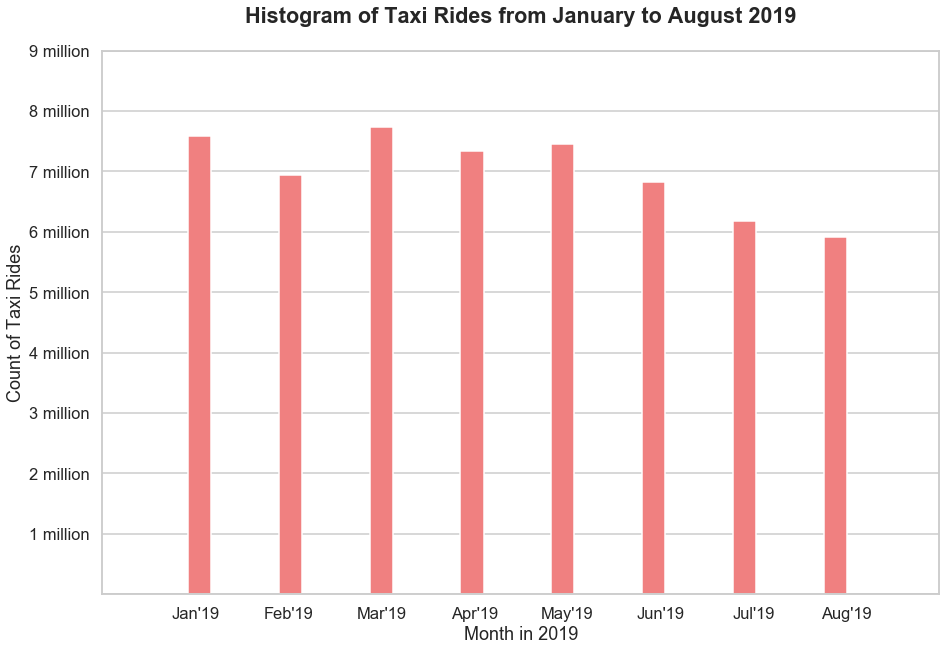

In [7]:
plt.figure(figsize=(15,10))
sns.set(context="talk", style="whitegrid", palette="bright")
g=sns.distplot(df["pickup_datetime"].dt.month, kde=False, hist_kws={"width":0.25,"align":"left","color":"lightcoral", 'alpha': 1})
g.xaxis.grid(b=False)
plt.xlim(0,9)
g.set_xticklabels(["","Jan'19","Feb'19","Mar'19","Apr'19","May'19","Jun'19","Jul'19","Aug'19"])
plt.yticks(g.get_yticks(), (g.get_yticks() * 1/0.002).astype(int))
g.set_yticklabels(["","1 million","2 million","3 million","4 million","5 million","6 million","7 million","8 million","9 million"])
plt.xlabel("Month in 2019")
plt.ylabel("Count of Taxi Rides")
plt.title("Histogram of Taxi Rides from January to August 2019", fontweight="bold", fontsize="large", y=1.04)
plt.show()

From January to August 2019, there was an average of 8 million taxi rides in NYC each month. There is a sizable variation in monthly taxi ridership, with March taxi rides outnumbering those in August by 1.82 million. 

Overall, there is a noticeable trend, possibly due to changes in weather or seasonal behavior, that monthly taxi ridership falls as the year goes on. 

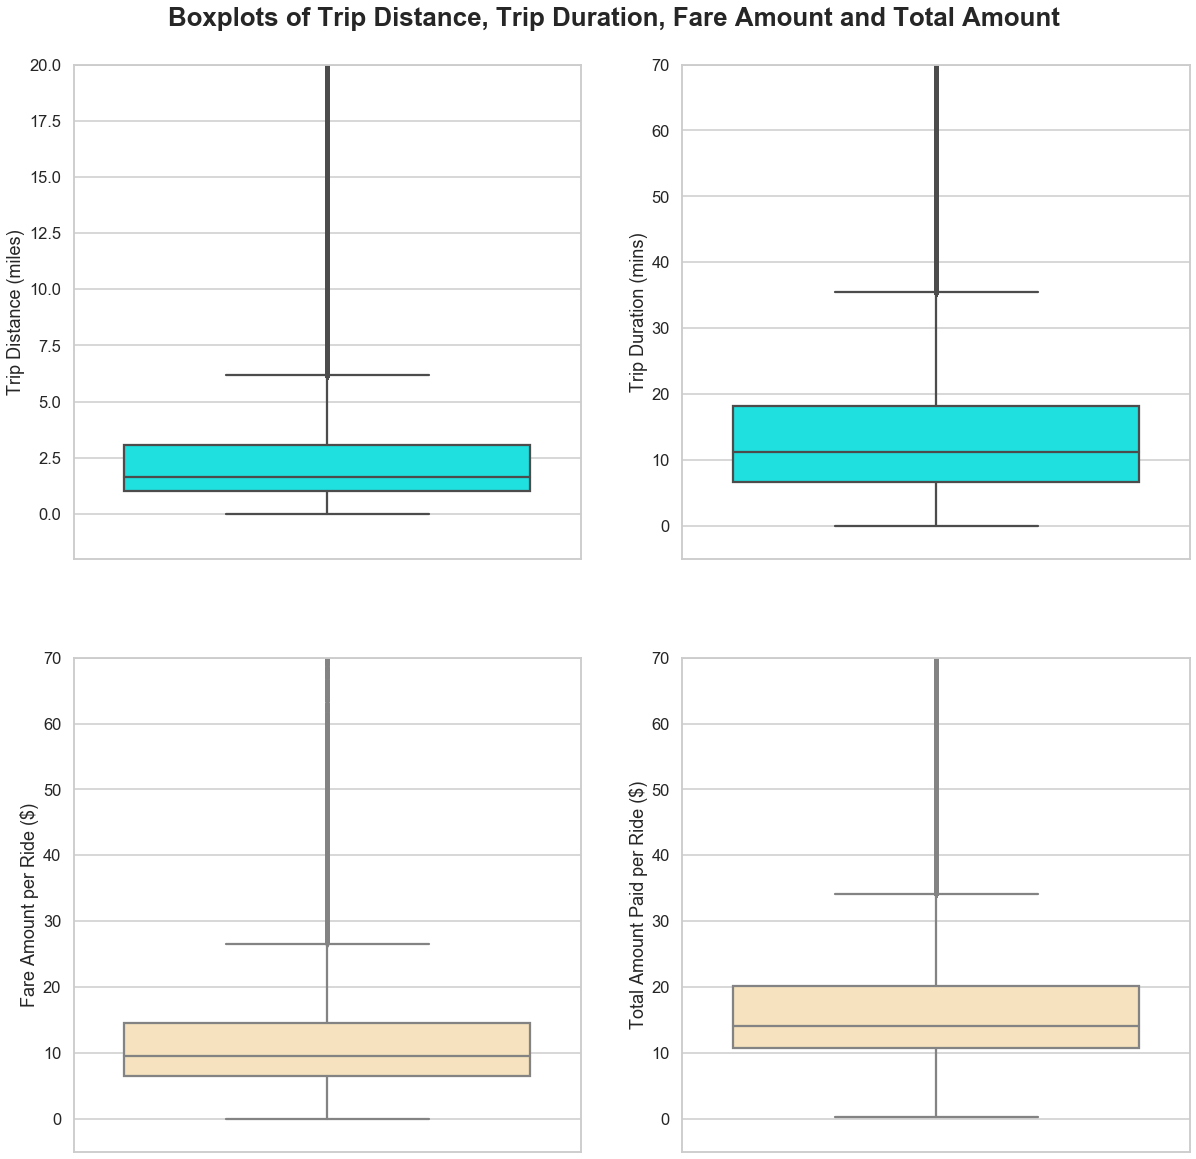

In [8]:
fig,axes=plt.subplots(2,2, figsize=(20,20))

a=sns.boxplot(y=df['trip_distance'], ax=axes[0,0],color="cyan").set(ylabel='Trip Distance (miles)')
axes[0,0].set(ylim=(-2, 20))

sns.boxplot(y=df['trip_duration_mins'], ax=axes[0,1],color="cyan").set(ylabel='Trip Duration (mins)')
axes[0,1].set(ylim=(-5, 70))


sns.boxplot(y=df['fare_amount'], ax=axes[1,0],color="moccasin").set(ylabel='Fare Amount per Ride ($)')
axes[1,0].set(ylim=(-5, 70))

sns.boxplot(y=df['total_amount'], ax=axes[1,1],color="moccasin").set(ylabel='Total Amount Paid per Ride ($)')
axes[1,1].set(ylim=(-5, 70))

fig.suptitle('Boxplots of Trip Distance, Trip Duration, Fare Amount and Total Amount', fontsize="x-large", fontweight="bold", y=0.92)
plt.show()

Looking at the top left boxplot, the vast majority of NYC taxi rides are short hops, with a median trip distance of just 1.64 miles and a narrow interquartile range of 2.07 miles. This is expected for a dense city like NYC where spaces for living, working, dining and recreation are in close proximity and do not require long-distance taxi rides to travel between. 

As for trip duration (depicted in the top right boxplot), the median stands at 11.13 minutes per ride. There is much more variation in trip durations, with a wide interquartile range of 11.5 minutes, which is unsurprising given the large variability in NYC traffic conditions. The median trip speed (which we calculated by dividing the distance variable over duration) is a slow 9.96 miles per hour. Perhaps some of these taxi commuters should consider using the subway!

For fare amount and total amount, there are a sizable number of outliers (such as fare amounts exceeding \\$300), thus it is justifiable to focus on the median instead of the mean. The median fare amount is \\$9.50, while the median total amount (which includes fares, tolls and tips) is \\$14.16, both of which are pretty expected for a taxi ride in NYC. 

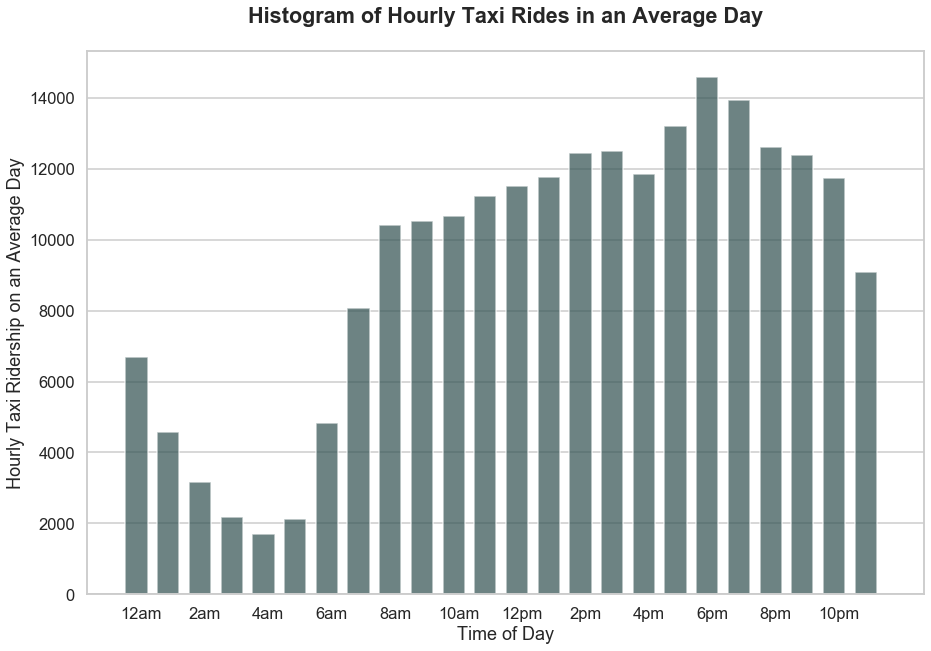

In [9]:
#scaling df to a daily time frame: dividing by 0.002 as we sampled 0.002 of dataset, and dividing by 242 as there are 242 days in our sample
scaled_daily_df = pd.concat([df]*round(1/0.002/242))

plt.figure(figsize=(15,10))
g=sns.distplot(pd.to_datetime(scaled_daily_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,1)-0.5, kde=False, hist_kws={"width":0.7, "color":"darkslategray", 'alpha': 0.7})
g.xaxis.grid(b=False)
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylabel("Hourly Taxi Ridership on an Average Day")
plt.title("Histogram of Hourly Taxi Rides in an Average Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

In [60]:
pd.to_datetime(scaled_daily_df['pickup_datetime']).dt.hour.value_counts()

18    14600
19    13936
17    13206
20    12624
15    12504
14    12456
21    12402
16    11852
13    11778
22    11738
12    11522
11    11226
10    10674
9     10532
8     10428
23     9086
7      8080
0      6678
6      4832
1      4580
2      3162
3      2182
5      2120
4      1708
Name: pickup_datetime, dtype: int64

What is the hourly distribution of NYC taxi rides like on an average day? 

As daylight breaks, there is a sharp jump in taxi rides from 6am onwards, and hourly taxi ridership doubles from 4,832 at 6-7am to 10,674 at 10-11am. Hourly taxi ridership remains high throughout the day, climbing through the lunchtime hours and afternoon, before reaching its daily peak of 14,600 at 6-7pm, when the office crowd gets off work. Thereafter, hourly ridership remains high until 11pm, after which there is a sharp dropoff in rides. 

Even in "The City That Never Sleeps", there is enormous variation in hourly taxi ridership throughout the day, with 8 times more rides at 6-7pm than at 4-5am. 

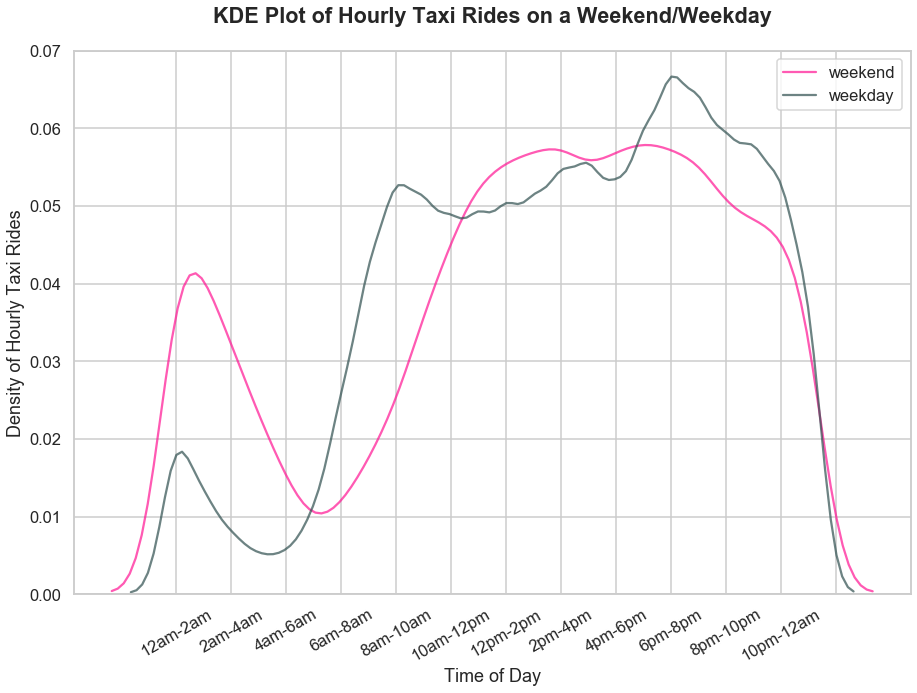

In [10]:
isweekend_df=scaled_daily_df.copy()
isweekend_df["isweekend"]=isweekend_df["pickup_dayofweek"].isin([5,6])
isweekend_df=isweekend_df.astype({'isweekend': 'int32'})

isweekend_y_df=isweekend_df[isweekend_df["isweekend"]==1]
isweekend_n_df=isweekend_df[isweekend_df["isweekend"]==0]

df[df["trip_duration_mins"]==0]["trip_distance"]

# accounting for how weekends occur 2/7 and weekdays occur 5/7 of the time
scaled_isweekend_y_df = pd.concat([isweekend_y_df]*5)
scaled_isweekend_n_df = pd.concat([isweekend_n_df]*2)

# f, axes = plt.subplots(1, 2, figsize=(20, 20), sharex=True)
plt.figure(figsize=(15,10))
sns.distplot(pd.to_datetime(isweekend_y_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend", kde_kws={"color":"deeppink", 'alpha': 0.7})
sns.distplot(pd.to_datetime(isweekend_n_df['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False,  label="weekday", kde_kws={"color":"darkslategray", 'alpha': 0.7})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.legend()
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday", fontweight="bold", fontsize="large", y=1.04)
plt.show()

As weekdays segue into weekends, ties are loosened, suits are cast aside and a different rhythm of taxi ridership emerges&mdash;as reflected by the stark shift in the distribution of hourly taxi rides. 

On weekends, a higher density of taxi rides occurs in the late night through early hours of the morning (12-4am), perhaps due to the large crowds staying out late for parties. There is also a sleepier start to a weekend morning, as suggested by a much lower&mdash;and less steep increase in&mdash;the density of taxi rides occurring from 6-10am. On weekday evenings, unsurprisingly, we do not see the same spike in taxi ridership that occurs from 5-8pm on weekdays as the office crowd knocks off from work. 

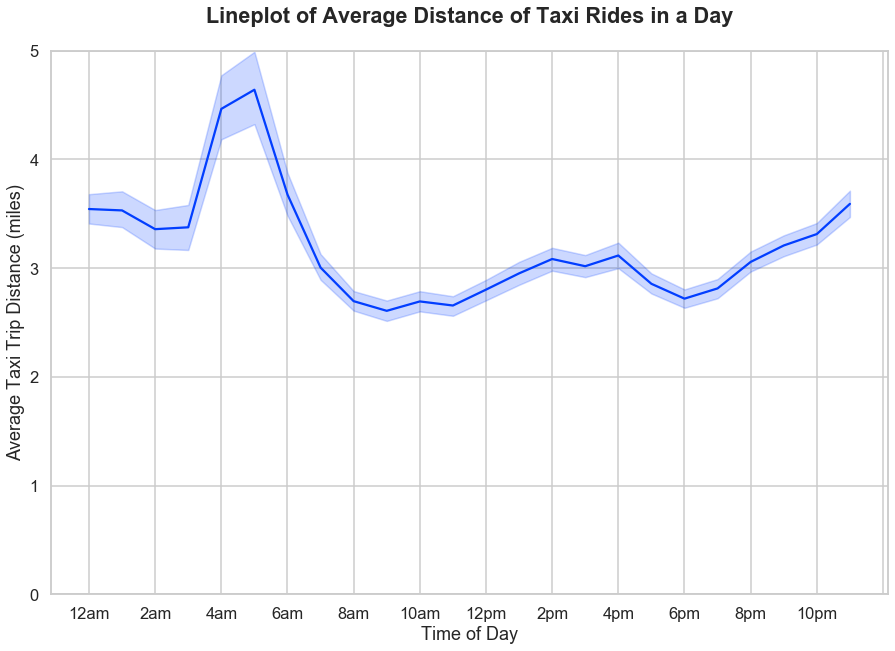

In [11]:
plt.figure(figsize=(15,10))
g=sns.lineplot(pd.to_datetime(df['pickup_datetime']).dt.hour, df["trip_distance"])
plt.xticks(np.arange(0,26, 2), labels=["12am","2am","4am","6am","8am","10am","12pm","2pm","4pm","6pm","8pm","10pm"])
plt.xlabel("Time of Day")
plt.ylim(0,5)
plt.ylabel("Average Taxi Trip Distance (miles)")
plt.title("Lineplot of Average Distance of Taxi Rides in a Day", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Looking at average taxi trip distance throughout a day could hold clues about the roles that taxis play in New Yorkers' daily lives. 

The lineplot above shows that average trip distance peaks at above 3.5 miles between 3 and 6am. Given that the KDE plot previously showed that the fraction of rides at that time is much higher on weekends, it is possible that many rides at that time are by partygoers who need a safe ride home (no matter how far home is). It could also be that NYC public transit services are operating at reduced frequencies from 3-6am, thus prompting more long-distance rides that substitute the role of public transit. 

The lower average trip distances from 8-11am suggest that yellow taxis are more used for shorter-distance commutes to work. For New Yorkers who live outside Manhattan (e.g. Queens, Brooklyn) and work in Manhattan, they would likely take green taxis ("Boro taxis") for the long-distance ride as those are more prevalent in other boroughs. 

Average taxi trip distance stays relatively steady for the remainder of the day, before rising in the late night, perhaps as New Yorkers use hail yellow taxis in Manhattan for outbound travel. 

Having uncovered key trends in NYC taxi ridership, we will proceed with the problem of predicting daily taxi ridership in NYC.  

# 3. A Daily Perspective: Which Variables are the Best Predictors of Daily Trip Counts?

## 3.1 Laying the Foundations

Now, we will explore the question of which variables are best used to predict daily trip counts. The search for an answer will uncover the hidden factors that drive millions of commuters' decisions to ride in yellow taxis each day. 

For this part, we will create a new dataframe ("trip_counts_df") that aggregates trip counts by dates. 

In our full dataset, there were two kinds of variables&mdash;trip-basis variables (e.g. `fare_amount`,`trip_distance`) and day-basis variables (e.g. `max_temp`,`date`). Here, we omit all trip-basis variables as they are no longer relevant from a daily perspective. 

In [12]:
trip_count_by_date_df = df.groupby("date")["pickup_datetime"].count()
trip_count_by_date_df = trip_count_by_date_df.to_frame(name="trip_count")
trip_count_by_date_df.reset_index(inplace=True)
trip_counts_df = trip_count_by_date_df.merge(df[["date","maxtemp","mintemp","avetemp","hdd","cdd","precipitation","newsnow","snowdepth","pickup_dayofweek"]], how="inner", on="date")

## 3.2 Dealing with Seasonality

We suspect that day-to-day taxi ridership would have a strong seasonal trend. For instance, large numbers of investment bankers would commute to work by taxi every Monday, but they might be spending time at home or playing golf (and hence not taking the taxi) every Sunday. We will use a time series plot to understand the seasonal trend&mdash;particularly the length of each season and the magnitude of fluctuation across seasons. 

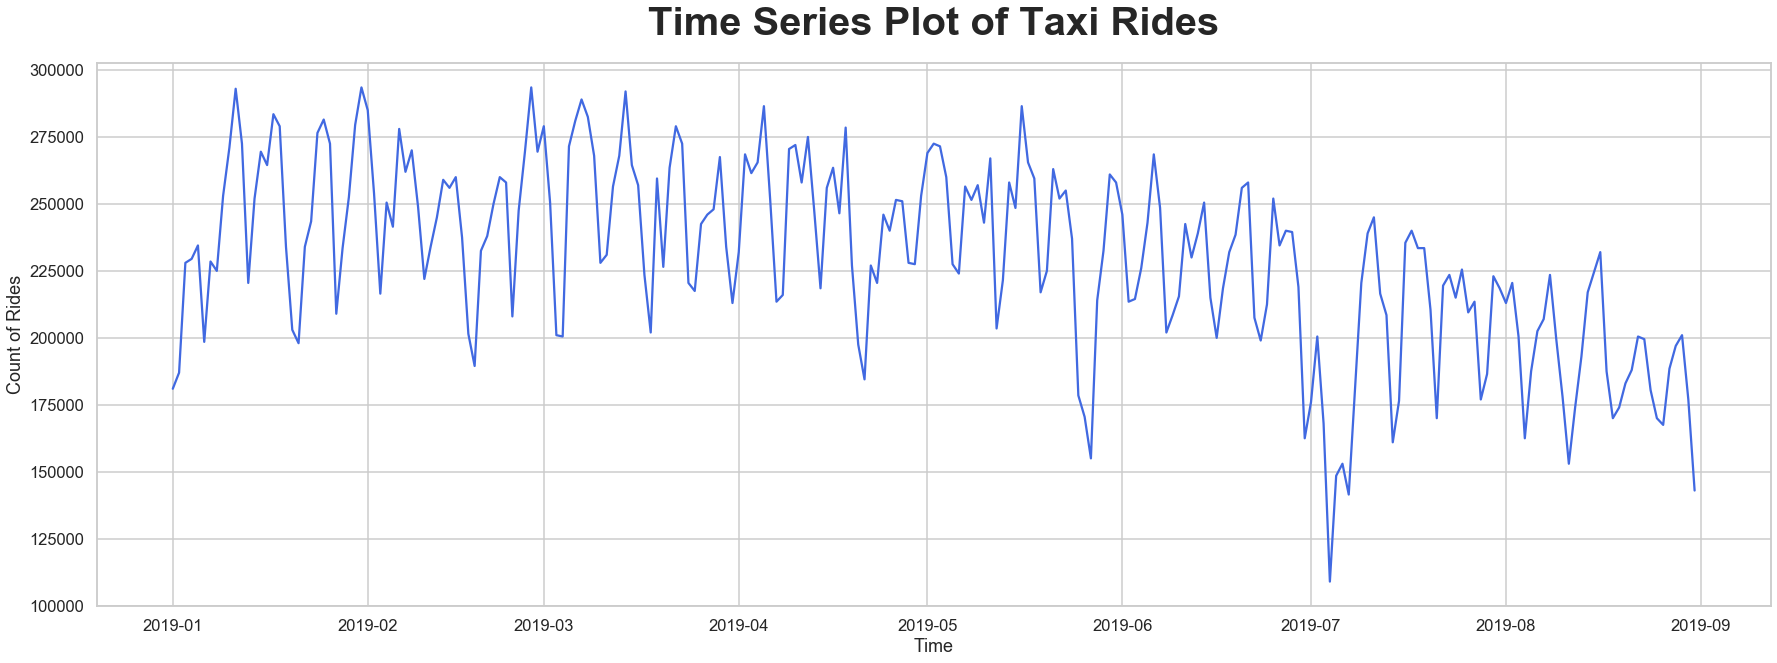

In [62]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(trip_counts_df["date"],trip_counts_df["trip_count"], color="royalblue")
ax.set_title("Time Series Plot of Taxi Rides", fontweight="bold", fontsize="40", y=1.04)
ax.set_xlabel("Time")
ax.set_ylabel("Count of Rides")
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
plt.show()

The time series plot shows approximately four peaks and troughs each month, thus indicating a weekly trend. The magnitude of fluctuation is very large, with a difference of up to 75,000 rides between each peak and trough. 

There is also a monthly trend, with monthly taxi ridership decreasing as the months go by.

To capture this seasonality in our dataset (and subsequent model), we will create the following variables:

- `isweekend`: a binary variable that codes whether the date is a weekend *(1: yes, 0: no)*
- 6 dummy variables for the day of week (`monday`, `tuesday`, `wednesday`, `thursday`,`friday`, `saturday` and `sunday`)
- 8 dummy variables for month of 2019 (`january`, `february`, `march`, `april`, `may`, `june`, `july`, `august`)

In [14]:
trip_counts_df["isweekend"]=np.where(trip_counts_df["pickup_dayofweek"].isin([5,6]),1,0)

# creating 6 dummy variables for day of week
PUdayofweek_dummies=pd.get_dummies(trip_counts_df["pickup_dayofweek"])
PUdayofweek_dummies.rename(columns={0:"monday",1:"tuesday",2:"wednesday",3:"thursday",4:"friday",5:"saturday",6:"sunday"}, inplace=True)
trip_counts_df=trip_counts_df.join(PUdayofweek_dummies)

# creating 8 dummy variables for month of 2019
PUmonth_dummies=pd.get_dummies(trip_counts_df["date"].dt.month_name())
trip_counts_df=trip_counts_df.join(PUmonth_dummies)
trip_counts_df.rename(columns={"January":"january","February":"february","March":"march","April":"april","May":"may","June":"june","July":"july","August":"august"}, inplace=True)

#reordering columns
trip_counts_df=trip_counts_df[['date', 'trip_count', 'maxtemp', 'mintemp', 'avetemp', 'hdd', 'cdd',
       'precipitation', 'newsnow', 'snowdepth', 'pickup_dayofweek',
       'isweekend', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday',
       'saturday', 'sunday', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august']]

In [15]:
trip_counts_df["pickup_month"]=trip_counts_df["date"].dt.month_name()

## 3.3 Examining Correlations with `trip_count` through Visualizations

First, we will use a correlation heatmap to identify explanatory variables with noticeable correlations with our response variable (`trip_count`). We are looking out for squares in the heatmap with a reddish or bluish hue (absolute correlations of more than 0.1). 

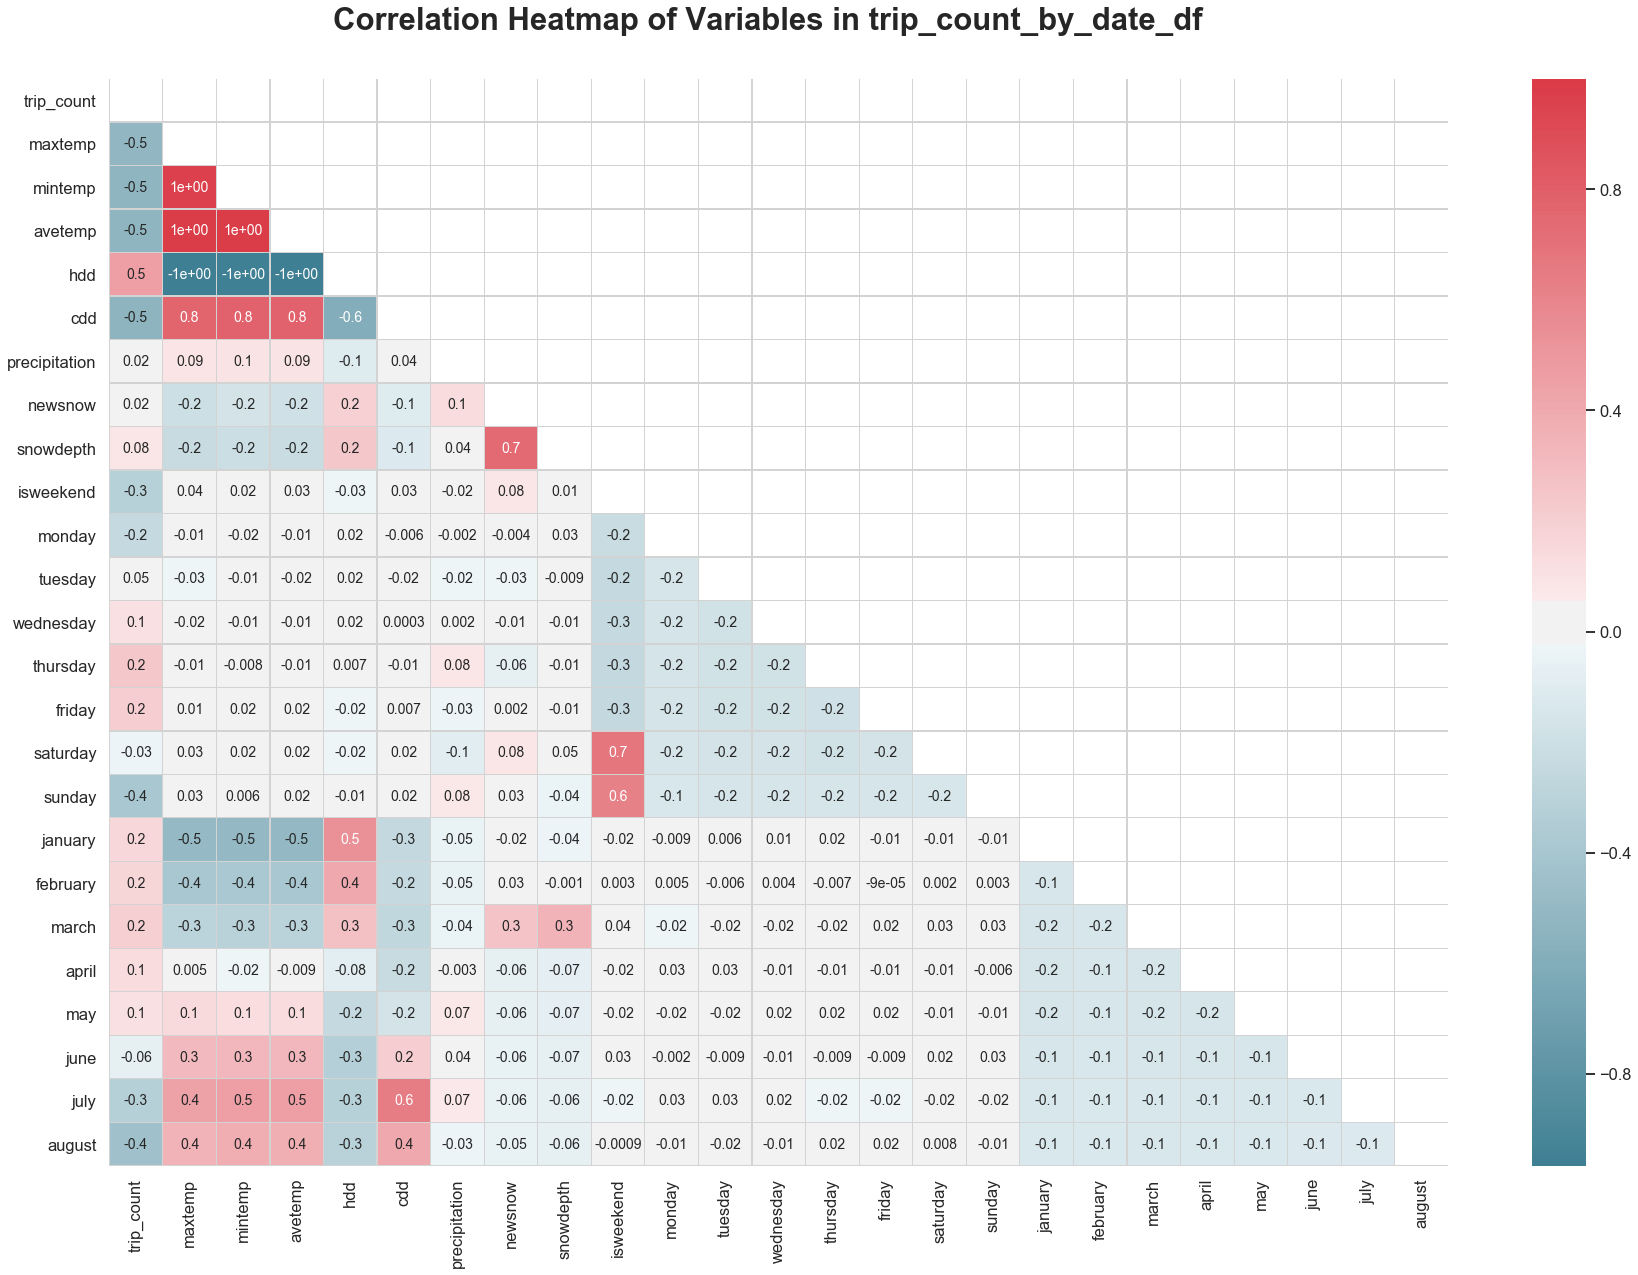

In [16]:
corr=trip_counts_df.drop(columns=["pickup_dayofweek", "pickup_month"]).corr()
plt.figure(figsize=(30, 20))
mask = np.tril(trip_counts_df.corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,annot_kws={"fontsize":14},fmt = '.1',  cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

#fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in trip_count_by_date_df", fontweight="bold", fontsize="xx-large", x=0.43, y=0.93)
plt.show()

Looking on the heatmap above, the explanatory variables that are noticeably correlated with `trip_count` are:
- Weather variables (`maxtemp`, `mintemp`, `avetemp`, `hdd` and `cdd`)


- Date-related variables, including `isweekend`, day of week dummies (`monday` to `sunday`) and month of 2019 dummies (`january` to `august`)

Contrary to our expectation hat rainy or snowy weather would increase taxi ridership (by reducing the favorability of transport options like biking or walking), precipitation and snowfall have only negligible correlations with `trip_count`. 

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and daily taxi ridership. 

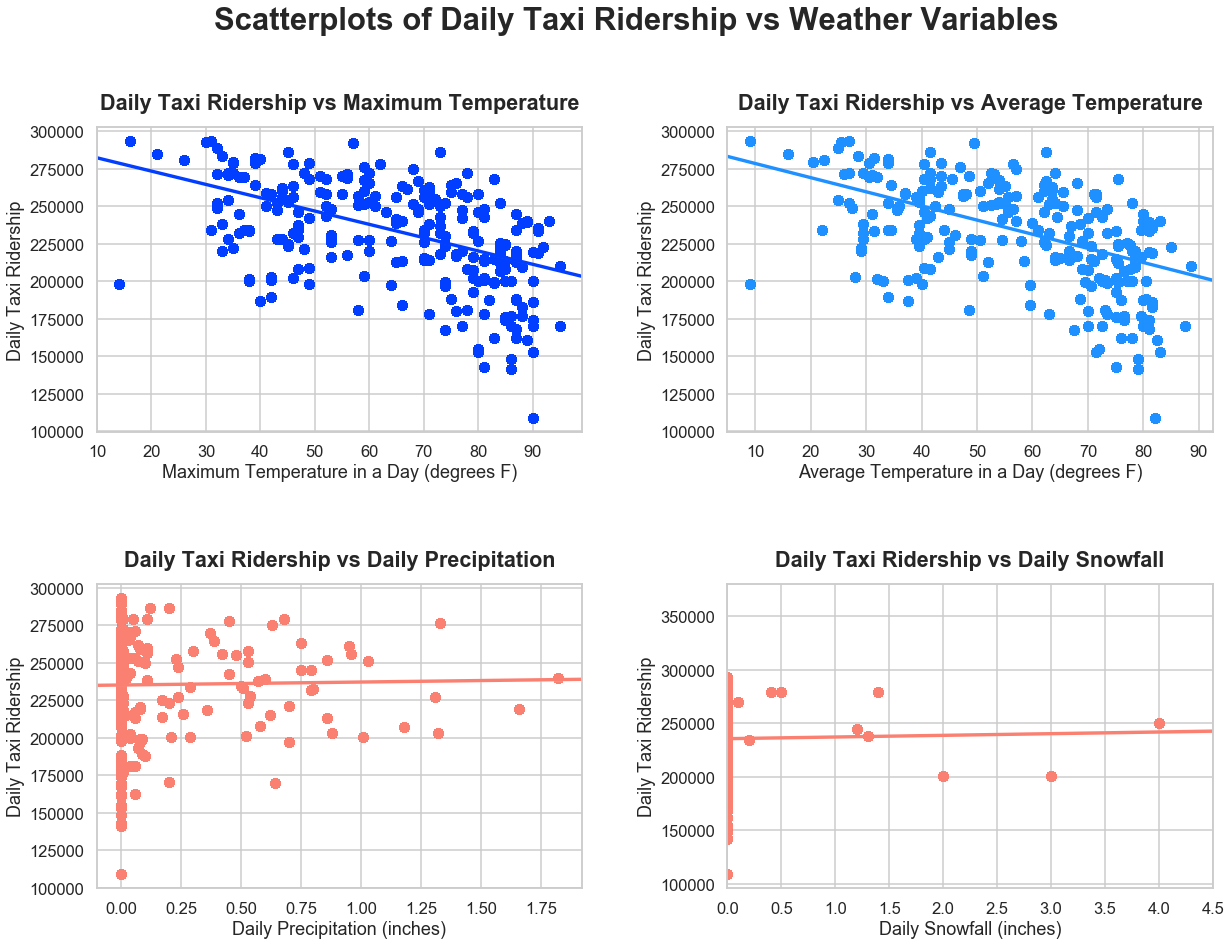

In [17]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.regplot(trip_counts_df["maxtemp"],trip_counts_df["trip_count"], ax=axes[0,0]).set(ylabel='Daily Taxi Ridership', xlabel="Maximum Temperature in a Day (degrees F)")
axes[0,0].set_yticklabels((axes[0,0].get_yticks() * 1/0.002).astype(int))
axes[0,0].set_title("Daily Taxi Ridership vs Maximum Temperature", fontweight="bold", fontsize="large", y=1.04)

sns.regplot(trip_counts_df["avetemp"],trip_counts_df["trip_count"], ax=axes[0,1], color="dodgerblue").set(ylabel='Daily Taxi Ridership', xlabel="Average Temperature in a Day (degrees F)")
axes[0,1].set_yticklabels((axes[0,1].get_yticks() * 1/0.002).astype(int))
axes[0,1].set_title("Daily Taxi Ridership vs Average Temperature", fontweight="bold", fontsize="large", y=1.04)

sns.regplot(trip_counts_df["precipitation"],trip_counts_df["trip_count"], ax=axes[1,0], color="salmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Precipitation (inches)")
axes[1,0].set_yticklabels((axes[1,0].get_yticks() * 1/0.002).astype(int))
axes[1,0].set_title("Daily Taxi Ridership vs Daily Precipitation", fontweight="bold", fontsize="large", y=1.04)

sns.regplot(trip_counts_df["newsnow"],trip_counts_df["trip_count"], ax=axes[1,1], color="salmon").set(ylabel='Daily Taxi Ridership', xlabel="Daily Snowfall (inches)")
axes[1,1].set_xlim(0,max(trip_counts_df["newsnow"])+0.5)
axes[1,1].set_yticklabels((axes[1,1].get_yticks() * 1/0.002).astype(int))
axes[1,1].set_title("Daily Taxi Ridership vs Daily Snowfall", fontweight="bold", fontsize="large", y=1.04)

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.suptitle("Scatterplots of Daily Taxi Ridership vs Weather Variables", fontweight="bold", fontsize="xx-large", y=1)

plt.show()



The top two scatterplots show that both maximum temperature (a proxy of daytime temperature) and average temperature are negatively correlated to daily taxi ridership. With an increase in maximum temperature, especially above the 60-degree mark, New Yorkers rely less on taxis. Perhaps, they turn to other forms of transportation such as the walking or Citi Bikes that are much more pleasurable without the bitter cold. 

Though `precipitation` appeared uncorrelated in the correlation heatmap, the bottom left scatterplot shows that precipitation is still related to taxi ridership. Low precipitation levels do not guarantee low daily taxi ridership (as evidenced by the high trip counts occurring on 0-precipitation days), but high precipitation levels are always accompanied by at least a moderate level of taxi ridership. 

Likewise, for daily snowfall, high snowfall days always have at least an moderate level of taxi ridership, but days with low or no snowfall have trip counts spanning the spectrum of low to high. Perhaps, the weak and ambiguous relationship between `newsnow` and `trip_counts` is due to the very few data points for snowy days (10 out of 243 days). 

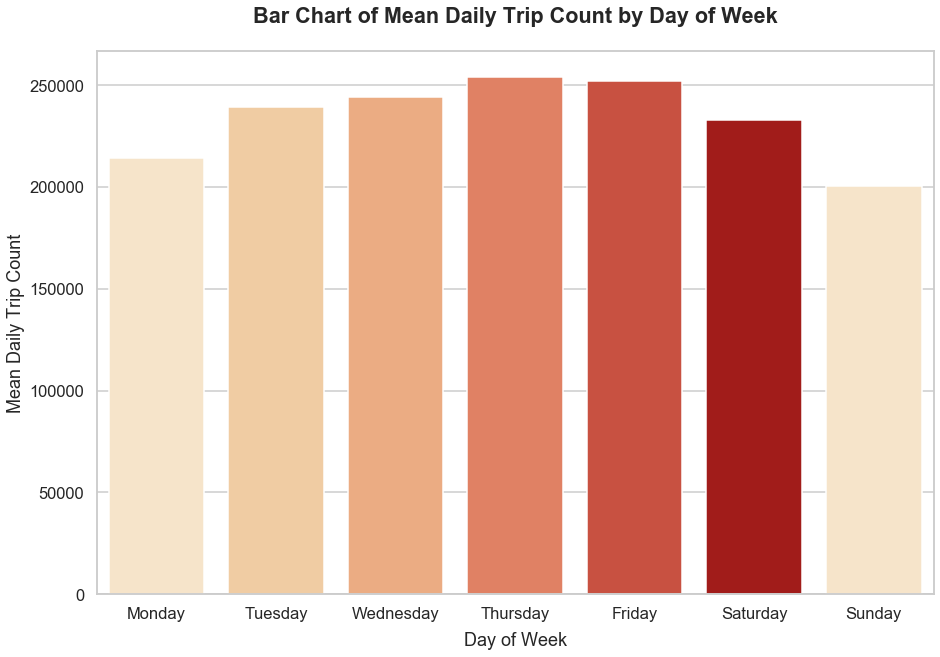

In [18]:
plt.figure(figsize=(15,10))
ax=sns.barplot(trip_counts_df["pickup_dayofweek"], trip_counts_df["trip_count"], ci=None, palette=sns.color_palette("OrRd"))
ax.set_xticklabels(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
ax.set_ylabel('Mean Daily Trip Count')
ax.set_xlabel('Day of Week', labelpad=10)
plt.title("Bar Chart of Mean Daily Trip Count by Day of Week", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Having deduced weekly seasonality from the time series previously, we would now like to analyze how taxi ridership actually rises and falls within a week. 

Across the days of a week, the mean daily trip count is lowest on Sunday, which is reasonable as taxi commutes to work or afterwork events do not occur on a rest day. Saturday has a higher mean trip count that Sunday, perhaps as it is only a partial rest day for some employees and many Friday night party-goers would ride taxis home on early Saturday morning. 

After Sunday, taxi ridership climbs day-by-day to reach its peak on Thursday, before falling as the weekend arrives. 

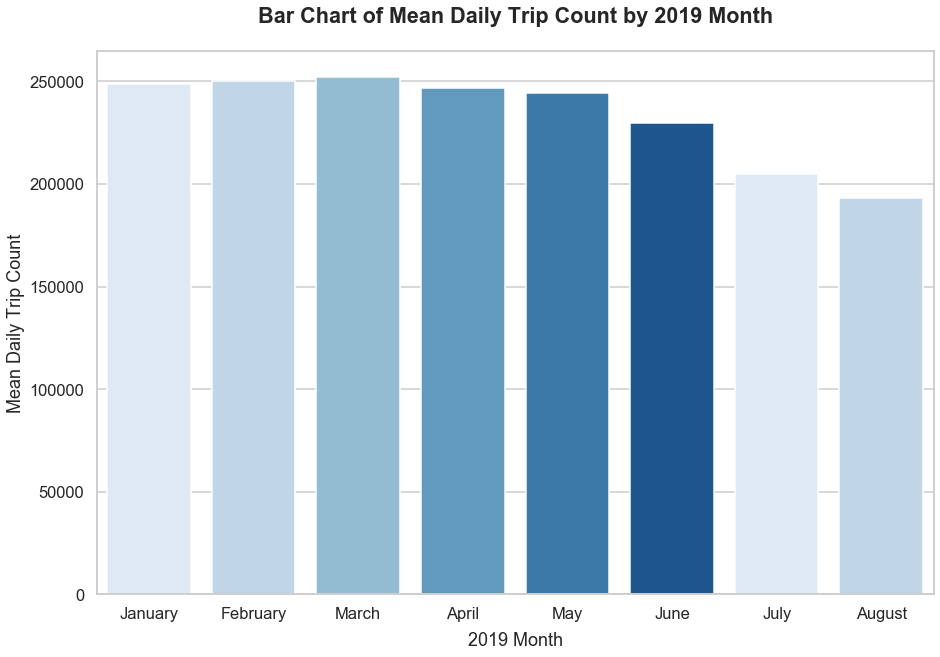

In [19]:
plt.figure(figsize=(15,10))
ax=sns.barplot(trip_counts_df["pickup_month"], trip_counts_df["trip_count"], ci=None, palette=sns.color_palette("Blues"))
ax.set_yticklabels((ax.get_yticks() * 1/0.002).astype(int))
ax.set_ylabel('Mean Daily Trip Count')
ax.set_xlabel('2019 Month', labelpad=10)
plt.title("Bar Chart of Mean Daily Trip Count by 2019 Month", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Echoing the trend of monthly decrease in the time series plot, the mean daily trip count over the 2019 months seems to have fallen at an exponential rate before tapering off at a low in August. 

This also agrees with what we see in the earlier correlation heatmap&mdash; that January 2019 had a 0.2 positive correlation with `trip_counts`, and this correlation fell exponentially over the months to reach -0.4 in August 2019. 

## 3.4 Linear Regression

### 3.4.1 Building of Model

We will use the Akaike’s Information Criterion (AIC) to select a linear regression model with the best relative quality—the best balance between goodness of fit and complexity. 

In [20]:
def minAIC_OLS(X,y):
    variables = X.columns
    model = sm.OLS(y,X[variables]).fit()
    while True:
        print(f'old model aic: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.OLS(y,X[newvariables]).fit()
        print(f'new model aic: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables
linear_model_cols=["maxtemp","avetemp", "precipitation","hdd","cdd","newsnow","snowdepth","tuesday","wednesday","thursday","friday","saturday","sunday","february","march","april","may","june","july","august"]
X=trip_counts_df[linear_model_cols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=trip_counts_df["trip_count"]
new_linear_model , linear_variables = minAIC_OLS(X,y)
new_linear_model = sm.OLS(y,X[linear_variables]).fit()
print(f"After Optimization, New model AIC is {new_linear_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_linear_model.params.index)}")

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Initial Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'snowdepth' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday'
 'february' 'march' 'april' 'may' 'june' 'july' 'august']

old model aic: 1114688.8061268884
new model aic: 1114695.4727836596
After Optimization, New model AIC is 1114688.8061268884

After Optimization, New Variables are ['const' 'maxtemp' 'avetemp' 'precipitation' 'hdd' 'cdd' 'newsnow'
 'snowdepth' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday'
 'february' 'march' 'april' 'may' 'june' 'july' 'august']


As the AIC cannot be reduced by removing any variables, our current linear model achieves the best fit (without overfitting) with the set of explanatory variables fed to it. Note that we omitted the `monday` and `january` dummy variables to avoid overparameterizing our model. 

In [21]:
results = new_linear_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             trip_count   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 1.418e+04
Date:                Thu, 14 May 2020   Prob (F-statistic):               0.00
Time:                        18:17:24   Log-Likelihood:            -5.5732e+05
No. Observations:              111953   AIC:                         1.115e+06
Df Residuals:                  111932   BIC:                         1.115e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1522.4144     28.227     53.935      0.000    1467.091    1577.738
maxtemp           1.0929      0.046     23.971      0.000       1.004       1.182
avetemp         -18.7480      0.442    -42.405      0.000     -19.615     -17.881
precipitation    18.3141      0.349     52.535      0.000      17.631      18.997
hdd             -15.6852      0.436    -35.999      0.000     -16.539     -14.831
cdd              16.9667      0.435     39.034      0.000      16.115      17.819
newsnow         -14.9317      0.430    -34.712      0.000     -15.775     -14.089
snowdepth         1.1615      0.395      2.944      0.003       0.388       1.935
tuesday          50.4497      0.402    125.433      0.000      49.661      51.238
wednesday        58.8955      0.402    146.367      0.000      58.107      59.684
thursday         79.0887      0.399    198.317      0.000      78.307      79.870
friday           78.8270      0.400    196.858      0.000      78.042      79.612
saturday         41.5529      0.409    101.486      0.000      40.750      42.355
sunday          -27.4379      0.427    -64.285      0.000     -28.274     -26.601
february         13.8534      0.420     33.000      0.000      13.031      14.676
march            31.8380      0.455     69.949      0.000      30.946      32.730
april            41.6487      0.560     74.359      0.000      40.551      42.747
may              44.3001      0.636     69.706      0.000      43.055      45.546
june             32.4594      0.749     43.343      0.000      30.992      33.927
july            -13.1823      0.916    -14.398      0.000     -14.977     -11.388
august          -42.2601      0.829    -50.978      0.000     -43.885     -40.635
==============================================================================
Omnibus:                    31830.830   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115334.111
Skew:                          -1.404   Prob(JB):                         0.00
Kurtosis:                       7.103   Cond. No.                     2.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Performing the joint F-test at the 5% significance level, we see that the F statistic's p-value is 0. Hence, we reject the null hypothesis that none of the explanatory variables are related to `trip_counts`. In other words, our model fits the data better than an intercept-only model. 

An R-squared value of 0.717 means that 71.7% of the variation in `trip_counts` about its mean can be explained by our current fitted model. Seasonality plays an large role in our model's fit&mdash;if we include only day of week dummies, our R-squared is lower at 0.621; if we exclude both day of week and month dummies, our R-squared falls to 0.341. 

Using a two-tailed t-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. All the explanatory variables have p-values of 0 (<0.025) and are thus significant.  

To draw meaningful interpretations from the results, we must multiply each coefficient by 1/0.002, as we sampled only 0.002 of all taxi rides in the raw dataset. 

In [22]:
scaled_value_coefs=pd.DataFrame(new_linear_model.params*1/0.002)
scaled_value_coefs.rename(columns={0: "Scaled Values"}, inplace=True)
scaled_value_coefs

,Scaled Values
const,761207.216098
maxtemp,546.473821
avetemp,-9374.009961
precipitation,9157.046863
hdd,-7842.604648
cdd,8483.355273
newsnow,-7465.834400
snowdepth,580.730617
tuesday,25224.827561
wednesday,29447.735929


Some key findings from the linear regression model include:

- Echoing the negative correlations between temperatures and `trip_count` we saw earlier, a 1-degree F increase in `avetemp` (average daily temperature) is linked to a drop in daily taxi ridership by 9,374 rides, when covariates are held constant. An increase in `maxtemp` is linked to a surprising increase in daily trip counts, suggesting that the negative correlations we observed earlier for `maxtemp` could be due to its interaction with `avetemp`. 


- A 1-inch increase in precipitation is linked to a 9,157 increase in daily trip counts, holding covariates constant, suggesting that more rain indeed spurs taxi commutes. There is a interesting relationship observed in snowfall. A 1-inch increase in `newsnow` (new daily snowfall) is associated with 7466 fewer daily rides, when covariates are held constant. It is possible that new snowfall affects the safety of roads and clogs up traffic, thus deterring people from commuting via taxi. `snowdepth` (accumulated snow) has a converse effect of increasing daily ridership slightly, which makes sense as snow accumulations from previous days do not clog up traffic, and may encourage people to commute by taxi instead of walking or biking. 


- Day of week has an important effect on `trip_count`. In a January week, a Sunday is linked to a decrease in daily trip counts by 13,719 rides, relative to a Monday. Thursday and Friday are linked to the largest increases in taxi ridership as compared to Monday, which matches the intuition we got in the bar chart earlier. Overall, we can see an day-by-day increase in taxi ridership from Monday till Friday, before a sharp drop in taxi ridership on Saturday and a sharper drop on Sunday. 


- Month has an outsize relationship with daily taxi ridership. When covariates are held constant (and on a Monday), February has 6,927 more daily rides than January, and daily taxi ridership continues to increase (in comparison to January) to reach a peak of 22,824 rides higher than January in May. It then falls drastically in the next 3 months such that August has 21,130 fewer daily rides than January. Interestingly, the exponential month-on-month decrease in daily rides that we gleaned from the bar chart and correlation matrix earlier no longer exists when we hold covariates constant. 

### 3.4.2 Evaluation of Model 

For us to be able to draw valid inferences, the linear regression model has to satisfy four assumptions: 

1. Model is linear in the predictors
2. Residuals have a constant variance (are homoskedastic)
3. Residuals are mutually independent
4. Residuals are normally distributed

We will test each of the assumptions above. 

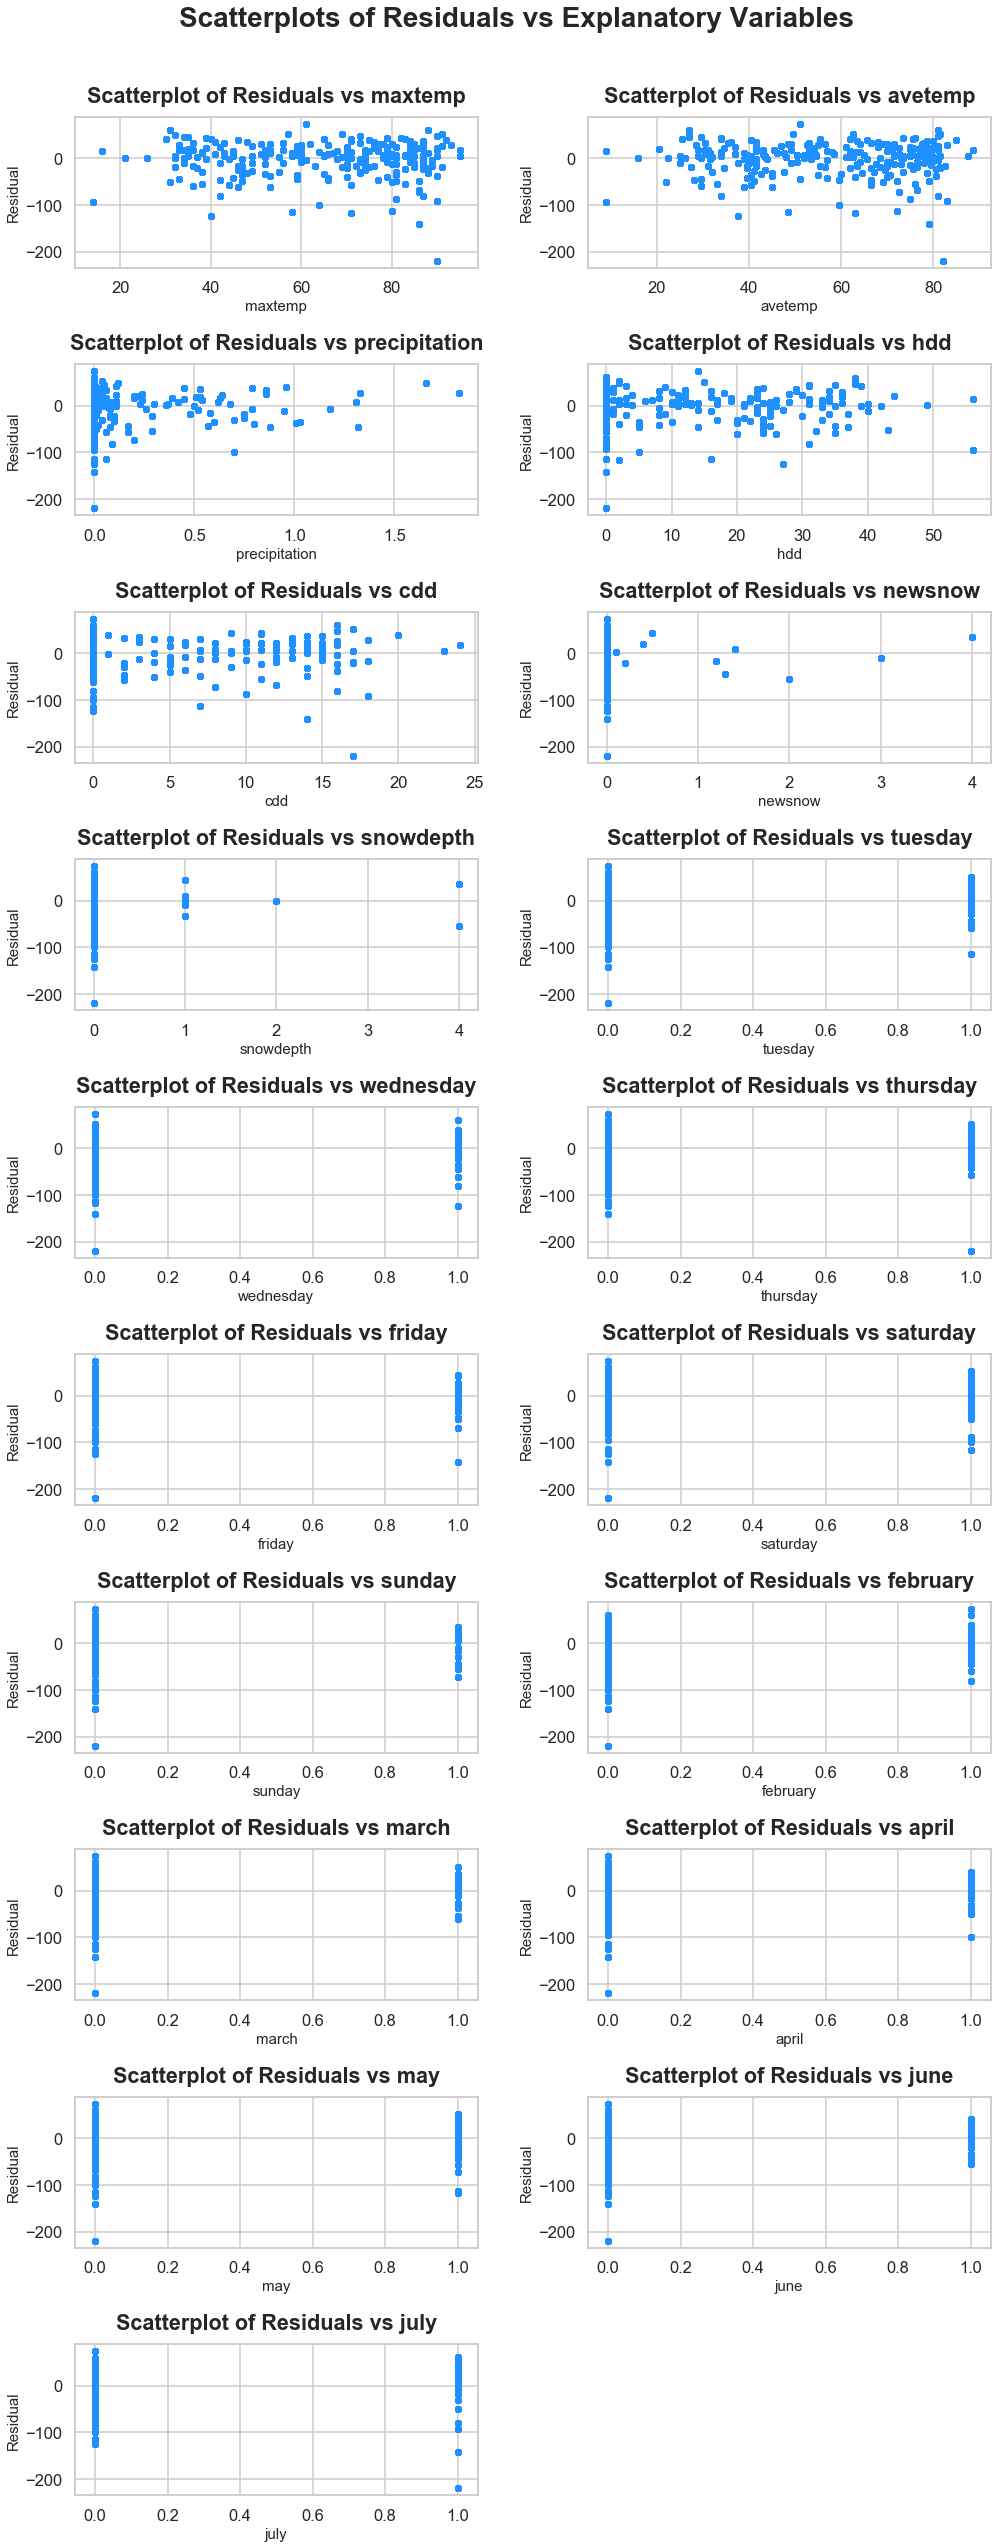

In [23]:
res=new_linear_model.resid
f, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,35))
f.delaxes(ax[9,1])
f.tight_layout(pad=3, h_pad=3.5)

for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],res, color="dodgerblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

1st Assumption Satisfied: Since the average values of the residuals do not depend on the values of each explanatory variable, our model is indeed linear in its predictors. 

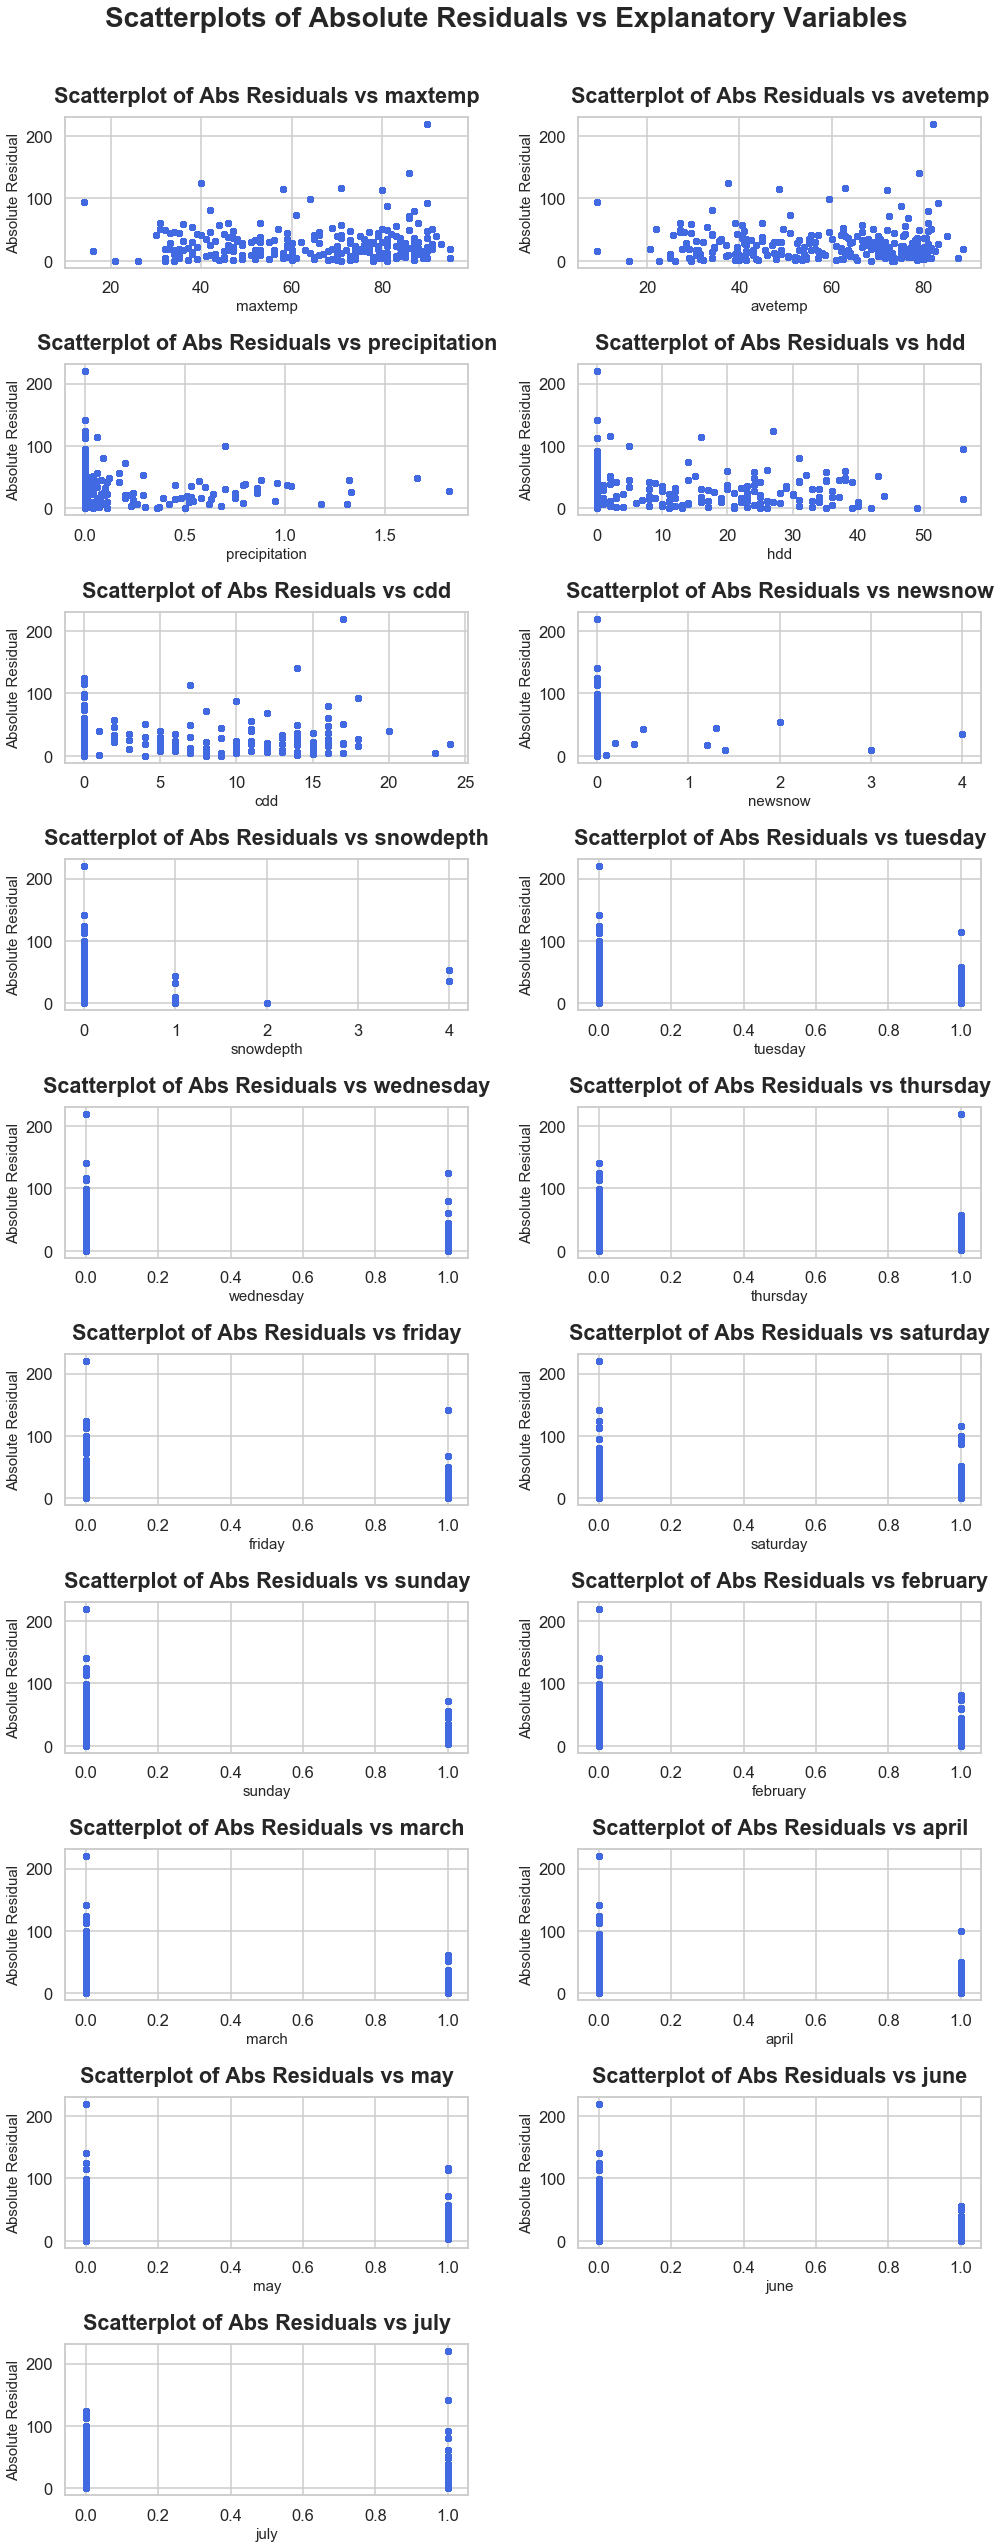

In [24]:
abs_res=np.abs(np.array(res))
f, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,35))
f.delaxes(ax[9,1])
f.tight_layout(pad=3, h_pad=3.5)

for c, colname in enumerate(linear_model_cols):
    rowindex = c//2
    colindex = 0 if c%2==0 else 1
    ax[rowindex][colindex].scatter(trip_counts_df[f"{colname}"],abs_res, color="royalblue", marker=".")
    ax[rowindex][colindex].set_title(f"Scatterplot of Abs Residuals vs {colname}", fontweight="bold", fontsize="large", pad=15)
    ax[rowindex][colindex].set_ylabel("Absolute Residual", fontsize=15)
    ax[rowindex][colindex].set_xlabel(f"{colname}", fontsize=15)
    f.suptitle('Scatterplots of Absolute Residuals vs Explanatory Variables', fontsize="28", fontweight="bold", y=1.02)
plt.show()

2nd Assumption Satisfied: Since the distribution of absolute residuals does not depend on value of each explanatory variable, the variance of the residuals is constant. 

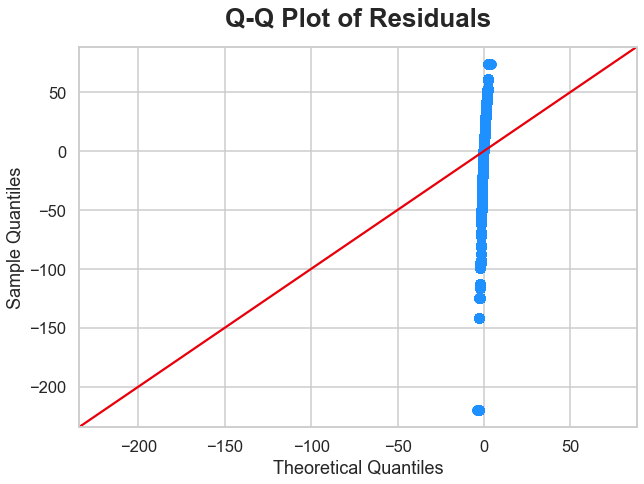

In [25]:
f, ax = plt.subplots(figsize=(10,7))
fig = sm.qqplot(res, line="45",ax=ax, color="dodgerblue")
ax.set_title("Q-Q Plot of Residuals", fontweight="bold", fontsize="x-large", y=1.04)
plt.show()

3rd Assumption Not Satisfied: Since the Q-Q plot of the residuals does not yield a straight 45-degree line, the residuals are not normally distributed.

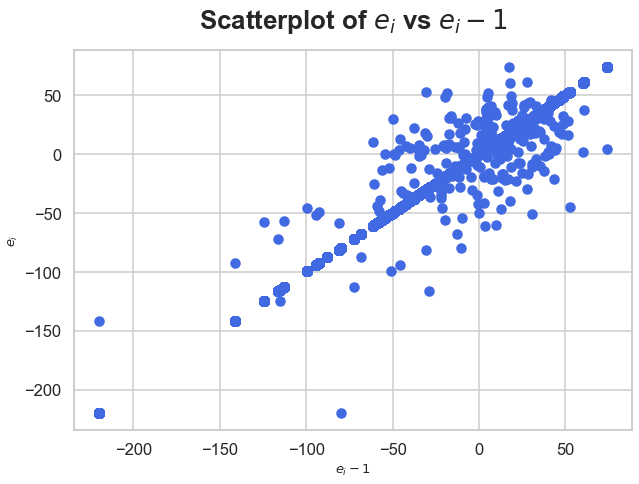

In [26]:
res=new_linear_model.resid
plt.figure(figsize=(10,7))
plt.scatter(res[:-1], res[1:], color="royalblue")
plt.title("Scatterplot of $e_i$ vs $e_i-1$", fontweight="bold", fontsize="x-large", y=1.04)
plt.ylabel("$e_i$", fontsize=13)
plt.xlabel("$e_i-1$", fontsize=13)
plt.show()

4th Assumption Not Satisfied: Since there is a clear relationship between consecutive residuals, residuals are not mutually independent. This is most likely due to the vulnerability of time series regression models to serial correlation (read more at http://people.duke.edu/~rnau/testing.htm). 

Overall, given that our linear model violates the assumptions of normal and mutually independent residuals, we would not proceed to predict `trip_counts` using it. The predictions that it generates could potentially be biased or misleading. 

# 4. Zooming into Manhattan: What Variables are Useful to Predict the Odds of a Downtown/Non-Downtown Ride?

## 4.1 Laying the Foundations

Now, we will dive into the question of which variables can help us predict the odds of a Manhattan taxi ride having a downtown pickup/dropoff location. For this part, we will create several new variables:
- `is_downtown`: a binary variable that codes whether a ride has a downtown pickup/dropoff location *(1: yes, 0: no)*


- `PUtime_of_day`: a variable that describes the time of day of a ride pickup *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- `DOtime_of_day`: a variable that describes the time of day of a ride dropoff *(early morning: 3am-7am, morning rush hour: 7am-11am, lunchtime: 11am-3pm, evening rush hour: 3pm-7pm, late evening: 7pm-11pm, late night: 11pm-3am)*


- 6 dummy variables for pickup time of day (`pickup_early_morning`, `pickup_morning_rush_hour`, `pickup_lunchtime`, `pickup_evening_rush_hour`,`pickup_late_evening` and `pickup_late_night`)


- 6 dummy variables for pickup time of day (`dropoff_early_morning`, `dropoff_morning_rush_hour`, `dropoff_lunchtime`, `dropoff_evening_rush_hour`,`dropoff_late_evening` and `dropoff_late_night`)

Before we start, we will import the taxi zone lookup table (adapted from https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv). This table maps pickup/dropoff location IDs to named locations in Manhattan, which we classified into 4 zones:

- Uptown: above 59th Street


- Midtown: 34th-59th Street


- Lower-Midtown: 14th-33rd Street


- Downtown: below 14th Street


We will also create a new dataframe with Manhattan-only rides and perform some data manipulation to ready it for logistic regression. 

In [91]:
isweekend_df=isweekend_df.drop_duplicates()

#importing taxi zone lookup dataset that has been preprocessed and tagged with Manhattan zones (Uptown, Midtown, Lower-Midtown, Downtown)
taxi_zone_lookup_df = pd.read_csv("taxi_zone_lookup.csv")

#merging isweekend_df with taxi_zone_lookup_df
lagg_df=isweekend_df.merge(taxi_zone_lookup_df,how="left",left_on=isweekend_df["PULocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"PUborough","Zone":"PUzone","service_zone":"PUservice_zone","manhattan_zone":"PUmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)
lagg_df=lagg_df.merge(taxi_zone_lookup_df,how="left",left_on=lagg_df["DOLocationID"], right_on=taxi_zone_lookup_df["LocationID"])
lagg_df.rename(columns={"Borough":"DOborough","Zone":"DOzone","service_zone":"DOservice_zone","manhattan_zone":"DOmanhattan_zone"},inplace=True)
lagg_df.drop(columns=["key_0","LocationID"],inplace=True)


#categorizing time of day into 6 names (early morning, morning rush hour, lunchtime, evening rush hour, late evening, late night)
lagg_df["PUtime_of_day"]=pd.to_datetime(lagg_df['pickup_datetime']).dt.hour
lagg_df.replace({"PUtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)
lagg_df["DOtime_of_day"]=pd.to_datetime(lagg_df['dropoff_datetime']).dt.hour
lagg_df.replace({"DOtime_of_day": {3:"early morning",4:"early morning",5:"early morning",6:"early morning",7:"morning rush hour",8:"morning rush hour",9:"morning rush hour",10:"morning rush hour",11:"lunchtime",12:"lunchtime",13:"lunchtime",14:"lunchtime",15:"evening rush hour",16:"evening rush hour",17:"evening rush hour",18:"evening rush hour",19:"late evening",20:"late evening",21:"late evening",22:"late evening", 23:"late night",0:"late night",1:"late night",2:"late night"}}, inplace=True)

#creating two datasets: one for taxi rides with Manhattan pickups and the other for taxi rides with Manhattan dropoffs
pu_manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])]
do_manhattan_df=lagg_df[~pd.isnull(lagg_df["DOmanhattan_zone"])]

#creating a larger dataset for taxi rides with Manhattan pickups or dropoffs
manhattan_df=lagg_df[~pd.isnull(lagg_df["PUmanhattan_zone"])|~pd.isnull(lagg_df["DOmanhattan_zone"])]

#splitting manhattan_df into two datasets based on whether a ride had downtown pickups/dropoffs
PUDO_downtown_y_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown")]
PUDO_downtown_n_df=manhattan_df[(manhattan_df["PUmanhattan_zone"]!="Downtown") & (manhattan_df["DOmanhattan_zone"]!="Downtown")]

#creating an is_downtown column to code downtown/non-downtown rides
manhattan_df["is_downtown"]=np.where((manhattan_df["PUmanhattan_zone"]=="Downtown") | (manhattan_df["DOmanhattan_zone"]=="Downtown"),1,0)

#replacing PUtime_of_day with 6 columns of dummy variables
PUtimeofday_dummies=pd.get_dummies(manhattan_df["PUtime_of_day"])
manhattan_df=manhattan_df.join(PUtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"pickup_early_morning", "morning rush hour":"pickup_morning_rush_hour", "lunchtime":"pickup_lunchtime", "evening rush hour":"pickup_evening_rush_hour", "late evening":"pickup_late_evening", "late night":"pickup_late_night"}, inplace=True)

#replacing DOtime_of_day with 6 columns of dummy variables
DOtimeofday_dummies=pd.get_dummies(manhattan_df["DOtime_of_day"])
manhattan_df=manhattan_df.join(DOtimeofday_dummies)
manhattan_df.rename(columns={"early morning":"dropoff_early_morning", "morning rush hour":"dropoff_morning_rush_hour", "lunchtime":"dropoff_lunchtime", "evening rush hour":"dropoff_evening_rush_hour", "late evening":"dropoff_late_evening", "late night":"dropoff_late_night"}, inplace=True)
manhattan_df.drop(columns=["PUtime_of_day","DOtime_of_day"], inplace=True)

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [92]:
manhattan_df["pickup_dropoff_early_morning"]=np.where((manhattan_df["pickup_early_morning"]==1) | (manhattan_df["dropoff_early_morning"]==1),1,0)
manhattan_df["pickup_dropoff_morning_rush_hour"]=np.where((manhattan_df["pickup_morning_rush_hour"]==1) | (manhattan_df["dropoff_morning_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_lunchtime"]=np.where((manhattan_df["pickup_lunchtime"]==1) | (manhattan_df["dropoff_lunchtime"]==1),1,0)
manhattan_df["pickup_dropoff_evening_rush_hour"]=np.where((manhattan_df["pickup_evening_rush_hour"]==1) | (manhattan_df["dropoff_evening_rush_hour"]==1),1,0)
manhattan_df["pickup_dropoff_late_evening"]=np.where((manhattan_df["pickup_late_evening"]==1) | (manhattan_df["dropoff_late_evening"]==1),1,0)
manhattan_df["pickup_dropoff_late_night"]=np.where((manhattan_df["pickup_late_night"]==1) | (manhattan_df["dropoff_late_night"]==1),1,0)

## 4.2 Examining Correlations with `is_downtown` through Visualizations

As a first step, we will run a correlation heatmap to identify the explanatory variables with noticeable correlations with our response variable (`is_downtown`). 

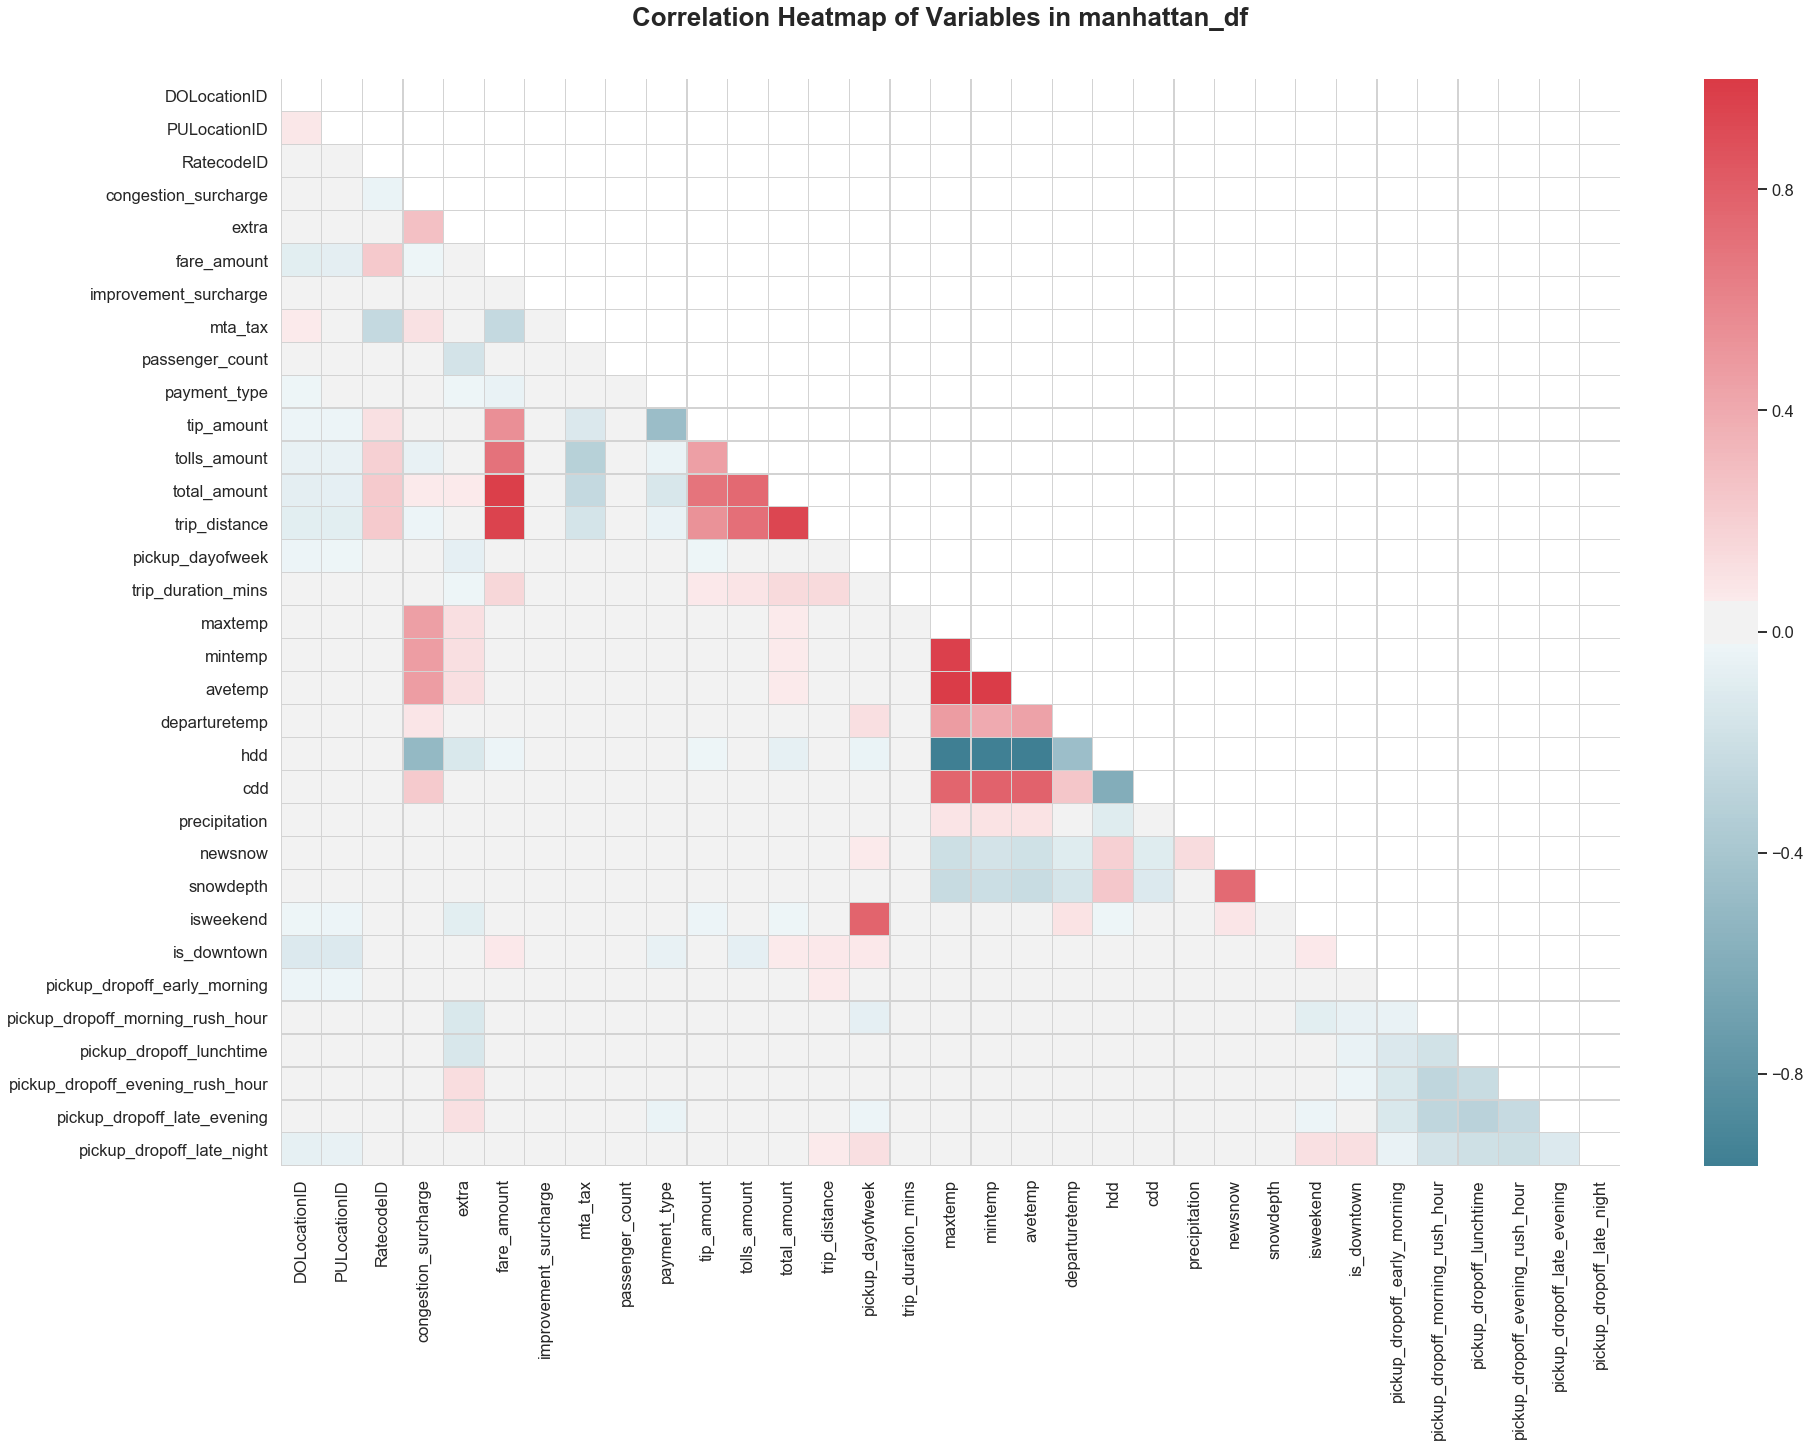

In [93]:
corr=manhattan_df.drop(columns=["pickup_early_morning","pickup_morning_rush_hour","pickup_lunchtime","pickup_evening_rush_hour","pickup_late_evening","pickup_late_night","dropoff_early_morning","dropoff_morning_rush_hour","dropoff_lunchtime","dropoff_evening_rush_hour","dropoff_late_evening","dropoff_late_night"]).corr()
plt.figure(figsize=(30,20))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),  mask = mask, linewidths=0.2, linecolor='lightgray')

#fix for seaborn bug where top and bottom boxes are cut off (adapted from https://github.com/mwaskom/seaborn/issues/1773)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.suptitle("Correlation Heatmap of Variables in manhattan_df", fontweight="bold", fontsize="x-large", x=0.43, y=0.93)
plt.show()

Looking on this heatmap, explanatory variables correlated with `is_downtown` include:
- Whether the taxi ride occurred on a weekend (`isweekend`) 
- Time of day (especially `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_lunchtime`, `pickup_dropoff_evening_rush_hour` and `pickup_dropoff_late_night`)
- Amount of payment (`fare_amount`,`tolls_amount` and `total_amount`)
- Distance logged in a taxi ride (`trip_distance`)
- Payment type (`payment_type`)

We will proceed with some visualizations to better understand the strength and direction of the relationship between these explanatory variables and `is_downtown`. 

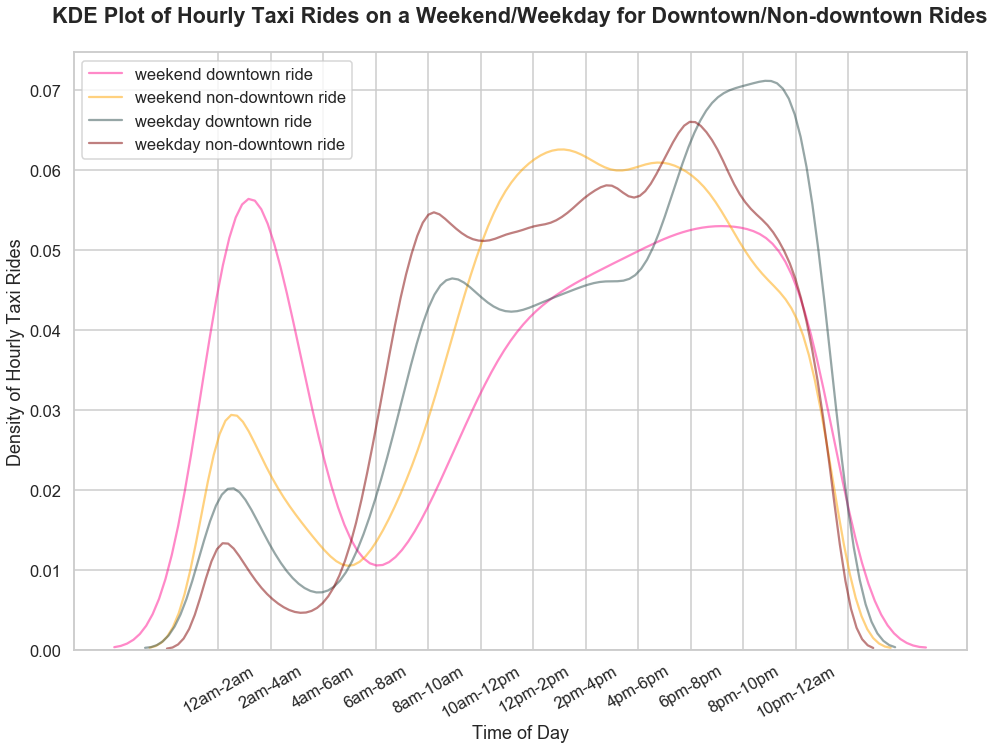

In [94]:
plt.figure(figsize=(16,11))
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend downtown ride", kde_kws={"color":"deeppink", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==1) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekend non-downtown ride", kde_kws={"color":"orange", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==1)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday downtown ride", kde_kws={"color":"darkslategray", 'alpha': 0.5})
sns.distplot(pd.to_datetime(manhattan_df[(manhattan_df["isweekend"]==0) & (manhattan_df["is_downtown"]==0)]['pickup_datetime']).dt.hour, bins=np.arange(0,25,2)-0.5, hist=False, label="weekday non-downtown ride", kde_kws={"color":"maroon", 'alpha': 0.5})
plt.xticks(np.arange(0,25,2), labels=["12am-2am","2am-4am","4am-6am","6am-8am","8am-10am","10am-12pm","12pm-2pm","2pm-4pm","4pm-6pm","6pm-8pm","8pm-10pm","10pm-12am"], rotation=30)
plt.xlabel("Time of Day")
plt.ylabel("Density of Hourly Taxi Rides")
plt.title("KDE Plot of Hourly Taxi Rides on a Weekend/Weekday for Downtown/Non-downtown Rides", fontweight="bold", fontsize="large", y=1.04)
plt.show()

Using a KDE plot, we discover the following: 
- On late nights (11pm-3am), the density of weekend downtown rides is much higher than that of weekday downtown rides, thus conforming with the correlation heatmap's results. It also makes sense as many late-night parties occur in the downtown area on weekends, drawing more taxi rides to and from downtown on weekends.


- On early mornings (3am-7am), the density of weekend downtown rides is higher than that of weekday downtown rides from 3-5am but dips below the gray line from 5-7am. the "canceling out" of opposite effects may explain why the correlation betwen early mornings and `is_downtown` is negligible. 


- On late evenings (7pm-11pm), the density of downtown rides (gray and pink lines) on average higher than that of non-downtown rides (represented by brown and yellow lines). This suggests that the late evening time window might be a good variable to use to predict `is_downtown` odds. 

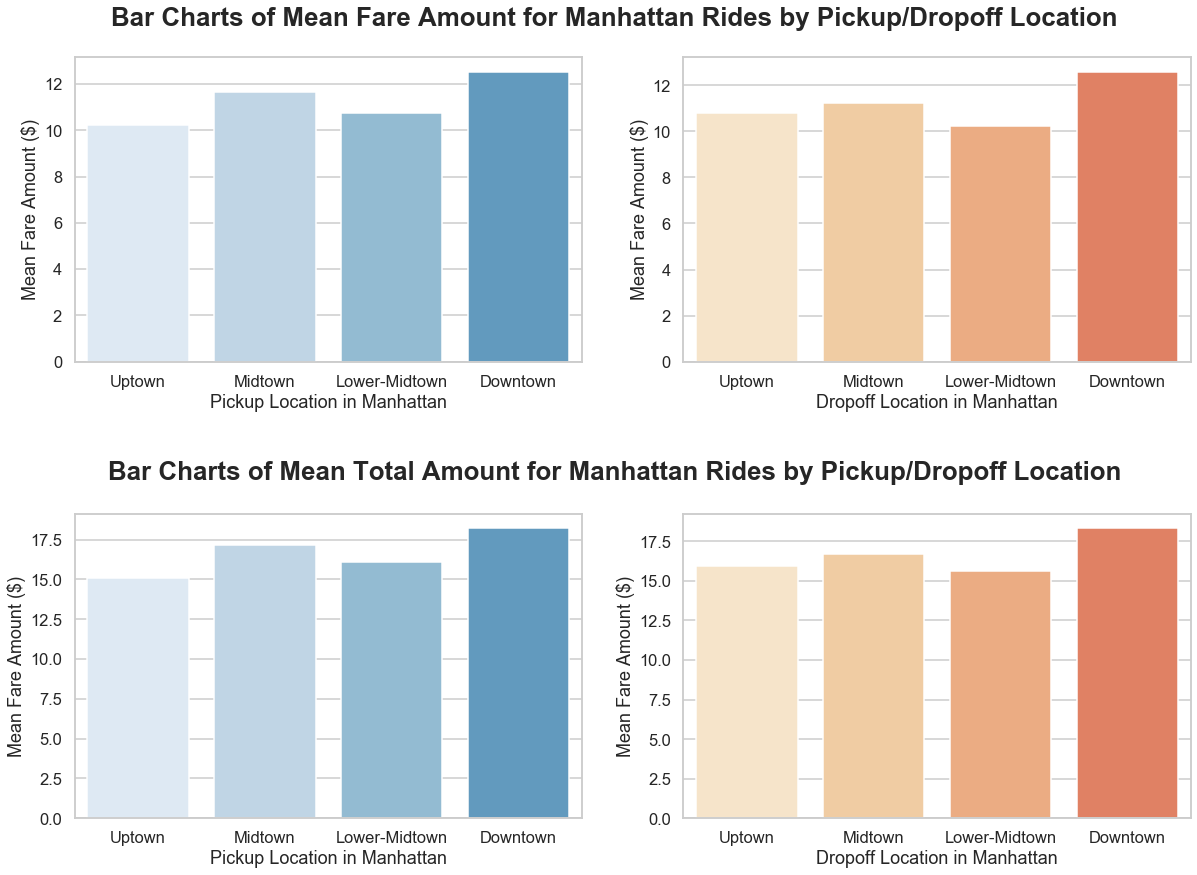

In [95]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["fare_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Fare Amount ($)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["total_amount"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Fare Amount ($)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Fare Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Total Amount for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

The bar charts above show that for both taxi pickups and dropoffs, the mean fare amount is significantly higher for the downtown area than the non-downtown area, thus echoing the positive correlation between `is_downtown` and `fare_amount`. The mean total amount (which includes fare amount, tip amount and tolls) is similarly higher for downtown rides than non-downtown rides. 

What is the intuition behind the higher mean fares in the downtown area? Fare amount is a influenced by both trip distance (\\$0.50 per 1/5 mile above 12mph) and trip duration (\\$0.50 per 60 seconds in slow traffic). Do downtown trips tend to clock a longer distance, or do they simply take a longer time traversing the same distance (have a lower speed)?

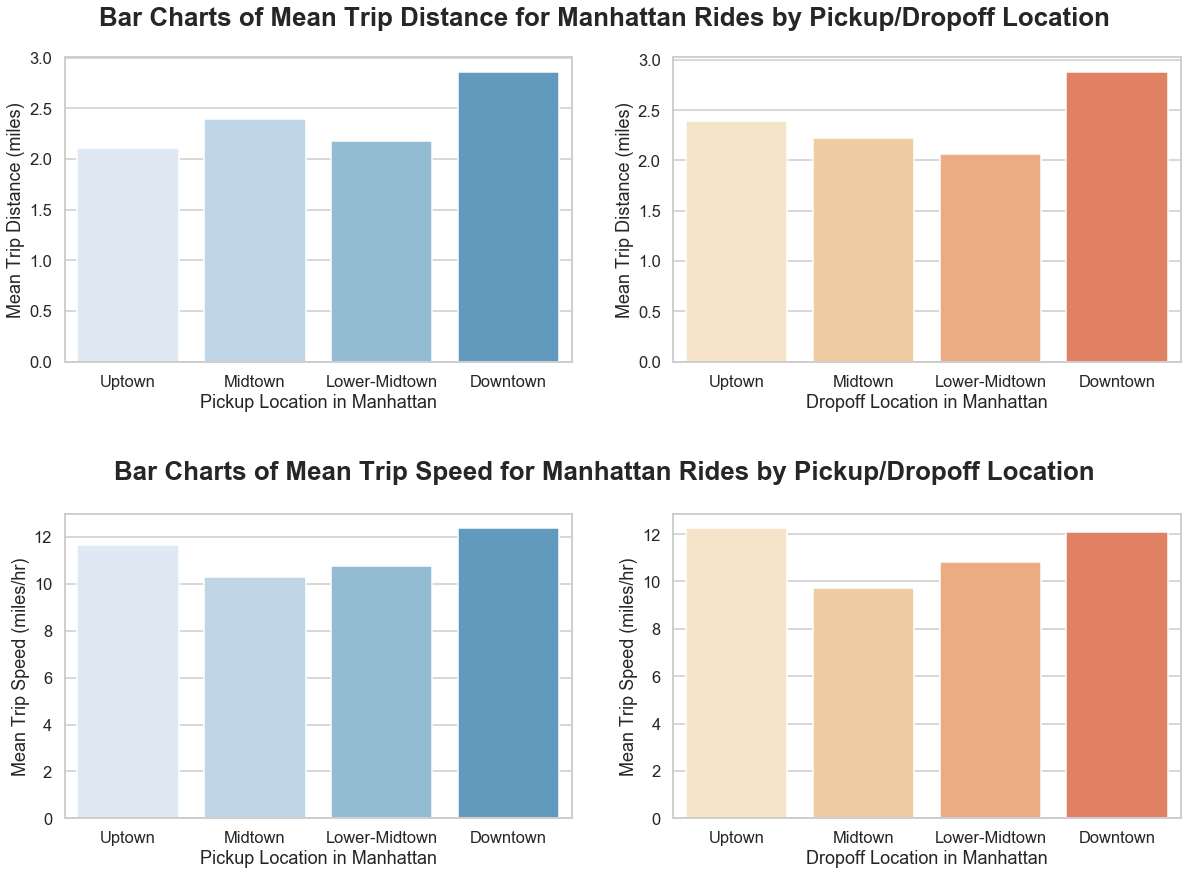

In [96]:
fig,axes=plt.subplots(2,2, figsize=(20,14))

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Trip Distance (miles)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"], order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[0,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Trip Distance (miles)', xlabel="Dropoff Location in Manhattan")

sns.barplot(pu_manhattan_df["PUmanhattan_zone"], pu_manhattan_df["trip_distance"]/pu_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,0], palette=sns.color_palette("Blues")).set(ylabel='Mean Trip Speed (miles/hr)', xlabel="Pickup Location in Manhattan")
sns.barplot(do_manhattan_df["DOmanhattan_zone"], do_manhattan_df["trip_distance"]/do_manhattan_df["trip_duration_mins"]*60, order=["Uptown", "Midtown", "Lower-Midtown", "Downtown"], ci=None, ax=axes[1,1],  palette=sns.color_palette("OrRd")).set(ylabel='Mean Trip Speed (miles/hr)', xlabel="Dropoff Location in Manhattan")

plt.figtext(0.5,0.93, "Bar Charts of Mean Trip Distance for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.figtext(0.5,0.48, "Bar Charts of Mean Trip Speed for Manhattan Rides by Pickup/Dropoff Location", ha="center", va="top", fontsize="x-large", fontweight="bold")
plt.subplots_adjust(hspace = 0.5 )

plt.show()

It turns out that trip distance is the main factor at play in creating the difference in fare amounts between downtown and non-downtown trips. For downtown rides, the mean trip distance is more than half a mile longer than the mean trips distances of uptown, midtown and lower-midtown rides. This could be due to the heavier reliance of taxis among employees in the downtown financial services industry to commute to and from home (in other Manhattan zones or NYC boroughs). 

The mean speed for downtown rides is actually greater than or equal to the mean speed of non-downtown rides, suggesting that "\\$0.50 per 60 seconds in slow traffic" component in taxi fares is lower for downtown rides (despite their higher mean fare amounts). 

## 4.3 Logistic Regression

### 4.3.1 Building of model

Like what we did for the linear regression model in Section 3.4, we will use the Akaike’s Information Criterion (AIC) to select a logistic regression model with the best relative quality&mdash;the best balance between goodness of fit and complexity. If our interpretations were accurate in Section 4.2, the mix of variables that yield the lowest AIC should largely be the same as those we identified. 

In [97]:
Xcols=["fare_amount", "total_amount", "tip_amount", "tolls_amount","payment_type", "trip_duration_mins", "trip_distance", "passenger_count", "isweekend", "precipitation", "avetemp","maxtemp","pickup_dropoff_early_morning", "pickup_dropoff_morning_rush_hour", "pickup_dropoff_evening_rush_hour", "pickup_dropoff_late_evening", "pickup_dropoff_late_night"]

def minAIC(X,y):
    variables = X.columns
    model = sm.Logit(y,X[variables]).fit()
    while True:
        print(f'Old model AIC: {model.aic}')
        maxp = np.max(model.pvalues)
        newvariables = variables[model.pvalues < maxp]
        newmodel = sm.Logit(y,X[newvariables]).fit()
        print(f'New model AIC: {newmodel.aic}')
        if newmodel.aic < model.aic:
            model = newmodel
            variables = newvariables
        else:
            break
    return model,variables

X=manhattan_df[Xcols]
X = sm.add_constant(X)
print(f"Initial Variables are {np.array(X.columns)}\n")
y=manhattan_df["is_downtown"]
new_model, logit_variables = minAIC(X, y)
new_model = sm.Logit(y, X[logit_variables]).fit()
print(f"After Optimization, New model AIC is {new_model.aic}\n")
print(f"After Optimization, New Variables are {np.array(new_model.params.index)}")

/Users/josiah/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Initial Variables are ['const' 'fare_amount' 'total_amount' 'tip_amount' 'tolls_amount'
 'payment_type' 'trip_duration_mins' 'trip_distance' 'passenger_count'
 'isweekend' 'precipitation' 'avetemp' 'maxtemp'
 'pickup_dropoff_early_morning' 'pickup_dropoff_morning_rush_hour'
 'pickup_dropoff_evening_rush_hour' 'pickup_dropoff_late_evening'
 'pickup_dropoff_late_night']

Optimization terminated successfully.
         Current function value: 0.531576
         Iterations 6
Old model AIC: 113082.00295924257
Optimization terminated successfully.
         Current function value: 0.531576
         Iterations 6
New model AIC: 113080.08710784321
Old model AIC: 113080.08710784321
Optimization terminated successfully.
         Current function value: 0.531581
         Iterations 6
New model AIC: 113078.97612446186
Old model AIC: 113078.97612446186
Optimization terminated successfully.
         Current function value: 0.531594
         Iterations 6
New model AIC: 113079.83568299052
Optimization ter

As expected, the variables with negligible correlation, namely `passenger_count` and `maxtemp`, fall out of the optimized model. 

However, there are some unexpected explanatory variables (with little correlation to `is_downtown` previously) added to the optimized model. These are `precipitation`, `avetemp`, `tip_amount`,`trip_duration_mins`. Some of these variables may not be significant, as we shall see later. 

The explanatory variables with a noticeable correlation to `is_downtown` previously have all been included in the optimized model. These factors are `fare_amount`, `total_amount`, `tolls_amount`, `payment_type`, `trip_distance`, `isweekend` and the time of day variables (`pickup_dropoff_early_morning`, `pickup_dropoff_morning_rush_hour`, `pickup_dropoff_evening_rush_hour`,`pickup_dropoff_late_evening` and `pickup_dropoff_late_night`). Notice that we excluded `pickup_dropoff_lunchtime` to avoid over-parameterizing the model. 

Next, we will proceed to interpret the p-values and coefficients of the logistic regression. 

In [98]:
results = new_model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_downtown   No. Observations:               106331
Model:                          Logit   Df Residuals:                   106315
Method:                           MLE   Df Model:                           15
Date:                Thu, 14 May 2020   Pseudo R-squ.:                 0.05056
Time:                        20:51:35   Log-Likelihood:                -56523.
converged:                       True   LL-Null:                       -59533.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -1.6769      0.043    -38.924      0.000      -1.761      -1.592
fare_amount                         -0.0790      0.009     -9.212      0.000      -0.096      -0.062
total_amount                         0.1017      0.008     12.349      0.000       0.086       0.118
tip_amount                          -0.0927      0.009     -9.873      0.000      -0.111      -0.074
tolls_amount                        -0.5349      0.013    -42.203      0.000      -0.560      -0.510
payment_type                        -0.2741      0.020    -13.436      0.000      -0.314      -0.234
trip_duration_mins                   0.0002   9.96e-05      1.715      0.086   -2.44e-05       0.000
trip_distance                        0.0819      0.008     10.740      0.000       0.067       0.097
isweekend                            0.3379      0.016     20.479      0.000       0.306       0.370
precipitation                       -0.0663      0.024     -2.801      0.005      -0.113      -0.020
avetemp                             -0.0009      0.000     -2.071      0.038      -0.002    -4.9e-05
pickup_dropoff_early_morning         0.1190      0.036      3.311      0.001       0.049       0.189
pickup_dropoff_morning_rush_hour    -0.0822      0.024     -3.416      0.001      -0.129      -0.035
pickup_dropoff_evening_rush_hour    -0.0456      0.022     -2.104      0.035      -0.088      -0.003
pickup_dropoff_late_evening          0.2570      0.021     12.445      0.000       0.217       0.298
pickup_dropoff_late_night            0.6222      0.025     25.390      0.000       0.574       0.670
====================================================================================================
"""

In [99]:
np.exp(new_model.params)

const                               0.186945
fare_amount                         0.924078
total_amount                        1.107026
tip_amount                          0.911452
tolls_amount                        0.585744
payment_type                        0.760285
trip_duration_mins                  1.000171
trip_distance                       1.085301
isweekend                           1.401983
precipitation                       0.935853
avetemp                             0.999087
pickup_dropoff_early_morning        1.126408
pickup_dropoff_morning_rush_hour    0.921055
pickup_dropoff_evening_rush_hour    0.955441
pickup_dropoff_late_evening         1.293109
pickup_dropoff_late_night           1.863021
dtype: float64

Using a two-tailed z-test at a 5% significant level, we reject the null hypothesis that a variable's coefficient is 0 if its upper-tail p-value is below 0.025. `trip_duration_mins`, `avetemp` and `pickup_dropoff_evening_rush_hour` are statistically insignificant as their p-values are 0.086, 0.038 and 0.035 respectively (both above 0.025). 

Some noteworthy findings from the logistic regression model include:

- A late-night time (as indicated by `pickup_dropoff_late_night`) increases the odds of a ride originating/ending in downtown by 86.3%, while a late-evening time (as indicated by `pickup_dropoff_late_evening`) boosts those odds by 29.3%. Echoing earlier visualizations, a weekend pickup or dropoff (as indicated by `is_weekend`) increases those odds by 40.2%. 


- A 1-mile increase in `trip_distance` boosts the odds of a downtown ride by 8.5%. 


- Hinting a trend of greater preference for (and ability to afford) credit cards among downtown taxi commuters, the use of card payments instead of cash, as indicated by a `payment_type` of 0 instead of 1, increases the odds of a downtown ride by 24%.


- Despite the positive correlation between `fare_amount` and the `is_downtown` in the correlation matrix, a \\$1 increase in fare amount leads to a 7.6\% decrease in the odds of a Manhattan ride having a downtown origin/destination. That being said, a \\$1 increase in `total_amount` is linked to a 10.7% increase in the odds of a downtown ride.



### 4.3.2 Evaluation of Model

We then train the logistic regression model on a training set and use it to predict `is_downtown` odds on a test set, with the goal of evaluating the model's classification ability.

In [100]:
logit_variables=list(logit_variables)
logit_variables.remove("const")
y=manhattan_df["is_downtown"]
X=manhattan_df[logit_variables]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
lgtmodel = LogisticRegression(solver = 'newton-cg').fit(X_train,y_train)

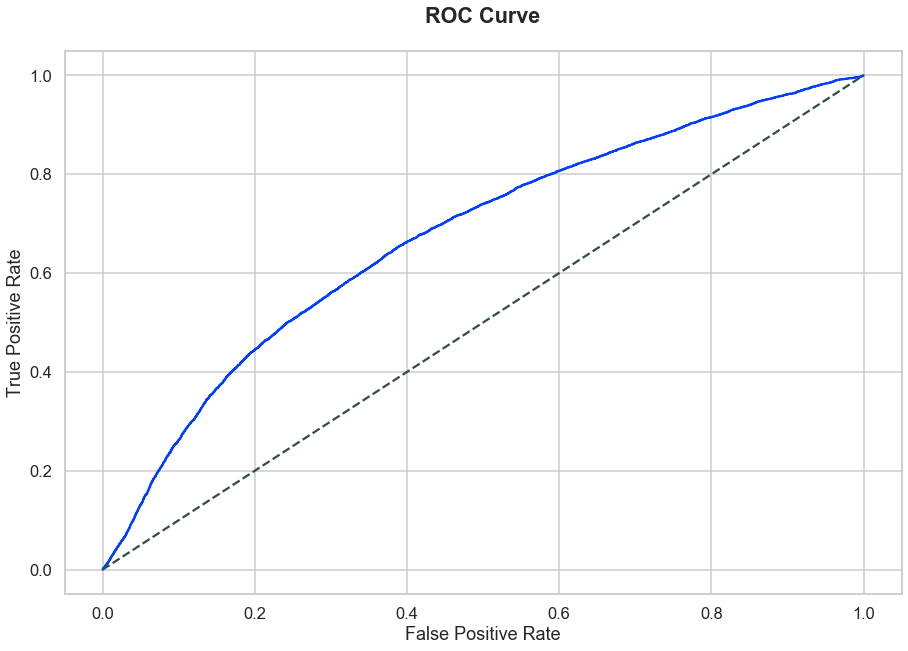

In [101]:
y_pred_probs = lgtmodel.predict_proba(X_test[logit_variables])[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.figure(figsize=(15,10))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],color="darkslategray", linestyle="dashed")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve", fontweight="bold", fontsize="large", y=1.04)
plt.show()

The ROC curve above illustrates the diagnostic ability of our model at different discrimination thresholds. With the goal of maximizing the true positive rate while minimizing the false positive rate, we select a threshold that matches a false positive rate of 0.38 for our model. 

In [111]:
y_pred = lgtmodel.predict_proba(X_test)[:,1]>0.22
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(confusion_matrix(y_test, y_pred))

[[12754 11208]
 [ 2242  5696]]


Based on the confusion matrix above, our model has 5696 true positives, 11208 false positives, 12754 true negatives and 2242 false negatives. This yields a true positive rate of 71.8% and a false positive rate of 46.8%. In other words, our model predicts that `is_downtown` is true when it is actually true 71.8% of the time , and it mistakenly predicts that `is_downtown` is true when it is actually false 46.8% of the time. 

In [112]:
lgtscore=lgtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Logistic Regression is {lgtscore}")

Mean Accuracy Score of Logistic Regression is 0.7473354231974921


Our logistic regression model yields a mean accuracy score of 0.747, meaning that it classifies `is_downtown` values correctly 74.7% of the time. Can we make better predictions with other binary classifiers?

## 4.4 Other Binary Classifiers

The other binary classifiers we experiment with are K Nearest Neighbors, random forests, adaptive boosting (AdaBoost) and decision trees. 

In [113]:
knmodel = KNeighborsClassifier(60)
knmodel.fit(X_train,y_train)
knscore=knmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of K Nearest Neighbors Classifier is {knscore}")

Mean Accuracy Score of K Nearest Neighbors Classifier is 0.7542319749216301


In [114]:
rfmodel = RandomForestClassifier(max_depth=5, n_estimators=5)
rfmodel.fit(X_train,y_train)
rfscore=rfmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Random Forest Classifier is {rfscore}")

Mean Accuracy Score of Random Forest Classifier is 0.7515360501567399


In [115]:
adbmodel = AdaBoostClassifier()
adbmodel.fit(X_train,y_train)
adbscore=adbmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Adaptive Boosting Classifier is {adbscore}")

Mean Accuracy Score of Adaptive Boosting Classifier is 0.7520689655172413


In [116]:
dtmodel = DecisionTreeClassifier(max_depth=10)
dtmodel.fit(X_train,y_train)
dtscore=dtmodel.score(X_test,y_test)
print(f"Mean Accuracy Score of Decision Trees Classifier is {dtscore}")

Mean Accuracy Score of Decision Trees Classifier is 0.7547021943573667


Among the four binary classifiers above, all of them have outperformed our logistic regression model slightly in terms of mean accuracy score. The model with the highest prediction accuracy is the decision trees classifier. 

# 5. Conclusion